## **IIb. Data augmentation - CTGAN - Default hyperparameters**
- Get the baseline performance of fidelity for each augmentation scenario for comparison with synthetic data generated from optimised versions in code IIa
- The format of this code is exactly as per that which uses optimised hyperparameters (code IIa) but instead of uses default hyperparameters - except for those changed due to computation issues (e.g. no. of epochs)
- Analyses undertaken on: CTGAN reliability; generator & discriminator performance; & fidelity of synthetic data samples
- Note that the 'balanced' dataset is considered the 'baseline' dataset for the 'baseline' model

Contents:

01. Set up access to packages and drives
02. User-defined functions
03. Prepare real data ahead of synthetic data generation
04. Find best hyperparameters for each augmentation scenario
05. Create augmented dataset for each scenario using best hyperparameters
06. Check reliability of CTGAN to create synthetic data of same quality repeatedly
07. Save all the key data created above for analysis & plotting into Google Drive
08. Load all the datasets required for analysis & plotting from Google Drive
09. Analysis : CTGAN generator & discriminator loss rates
10. Analysis : Stability of CTGAN
11. Analysis : Feature distribution analysis - real versus synthetic
12. Analysis : Feature correlations - real versus synthetic


### 1. Set up access to packages and drives

In [ ]:
# Install generator packages (run once per session)
!pip install ydata-synthetic==1.1.0
!pip install ctgan

from google.colab import drive
import pandas as pd
import numpy as np
from ctgan import CTGAN
from ydata_synthetic.synthesizers.regular import RegularSynthesizer
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from IPython.display import Image
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from sklearn.model_selection import ParameterGrid
import ast
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
from io import StringIO
import sys
import pickle
import time

# Suppress warning messages
import warnings
warnings.filterwarnings("ignore")
#warnings.filterwarnings("default") # To reset back to warnings

# Get access to Google Drive (run once per session)
drive.mount('/content/drive')

### 2. User-defined functions

In [ ]:
########## Pairwise Correlation Difference (PCD) metric - calculated at matrix-level ##########

def pcd(act,synth):
    act_corr=act.corr().values.flatten()
    act_corr=act_corr+0.0000000001
    synth_corr=synth.corr().values.flatten()
    synth_corr=synth_corr+0.0000000001
    pcd_metric=np.linalg.norm(act_corr-synth_corr)
    return pcd_metric

########## Maximum Mean Discrepancy (MMD) metric - calculated at matrix-level ##########

# Calculate Gaussian kernel matrix for two sets of data starting with sigma=1 (bandwidth of kernel)
def gauss_kern(a,b,sigma):
    diff=np.linalg.norm(a[:,np.newaxis]-b[np.newaxis,:],axis=-1)
    return np.exp(-0.5*(diff/sigma)**2)

def mmd(act,synth,sigma):
    # Convert df to arrays
    act_vals,synth_vals=act.values+0.0000000001,synth.values+0.0000000001
    # Calculate MMD metric
    act_kern=gauss_kern(act_vals,act_vals,sigma)
    synth_kern=gauss_kern(synth_vals,synth_vals,sigma)
    cross_kern=gauss_kern(act_vals,synth_vals,sigma)
    mmd_metric=np.mean(act_kern)+np.mean(synth_kern)-2*np.mean(cross_kern)
    return mmd_metric

########## Kullback–Leibler Divergence (KLD) metric - calculated at feature-level ##########

# Calculate KLD for two dataframes by averaging scores for column pairs
# Input arguments are dataframes

def kld(act,synth):
  kld_vals=[]
  for col in act.columns:
  # As there are differences in the lengths of the real & synthetic columns need to make them equal using sampling so that the KLD scores can be calculated (KLD requires equal lengths)
    if len(synth[col])>len(act[col]):
      synth_adj=synth[col].sample(n=len(act[col]),replace=False,random_state=42).reset_index(drop=True)
      act_adj=act[col]
    elif len(synth[col])<len(act[col]):
      act_adj=act[col].sample(n=len(synth[col]),replace=False,random_state=42).reset_index(drop=True)
      synth_adj=synth[col]
    else:
      act_adj=act[col]
      synth_adj=synth[col]
    # Extract the values from the respective features and add smoothing constant to avoid NaN
    act_vals=act_adj.values+0.0000000001
    synth_vals=synth_adj.values+0.0000000001
    # Create necessary probability distributions of feature pair
    act_prob=act_vals/np.sum(act_vals)
    synth_prob=synth_vals/np.sum(synth_vals)
    # Calculate KLD metric for feature pair
    kld=np.sum(act_prob*np.log1p(act_prob/synth_prob))
    kld_vals.append(kld)
  # Calculate KLD mean score overall all pairs
  kld_mean=np.mean(kld_vals)
  return kld_mean

########## Find best hyperparameters for data augmentation ##########

def data_aug_grid(dataset, target_class, num_synth_samples):

  start=time.time()

  # Set up metrics dictionary
  metrics={}

  # Hyperparameter grid

  # param_grid = {'batch_size': [20, 50],
  #               'lr': [0.0001, 0.005, 0.01],
  #               'betas': [(0.5, 0.9), (0.9, 0.9)],
  #               'noise_dim': [32, 64],
  #               'epochs': [10]}

  # Use default hypers but limit number of epochs due to computation restrictions
  param_grid = {'batch_size': [500],
                'lr': [0.005], # 0.005 and 0.01 - Note that some papers use 0.0002
                'betas': [(0.5, 0.9)],
                'epochs': [10]}

  # Defaults:
  # generator_dims: Dimensions of each hidden layer in the generator. Default: [256, 256]
  # critic_dims: Dimensions of each hidden layer in the critic. Default: [256, 256]
  # tau: Gumbel-Softmax non-negative temperature. Default: 0.2
  # gp_lambda: Gradient penalty lambda. Default: 10.0
  # l2_scale: L2 regularization scale. Default: 1e-6
  # g_lr: Generator learning rate. Default: 1e-4
  # d_lr: Critic learning rate. Default: 1e-4
  # beta_1: Adam optimizer beta_1 parameter. Default: 0.5
  # beta_2: Adam optimizer beta_2 parameter. Default: 0.9
  # batch_size: Batch size. Default: 64
  # epochs: Number of training epochs. Default: 300
  # pac: Population of Approximate Critic (PAC) size. Default: 10
  # noise_dim: 128

  # Create a list of all hyperparameter combinations (only one in the case of using default hyperparameters)
  param_combs = list(ParameterGrid(param_grid))

  i=0

  # Create synthetic data for each hyperparameter combination & evaluate its fidelity
  for params in param_combs:

      # Monitoring output (total of 108 hyperparameter combinations)
      print()
      print('Hyperparameter combination',i,'-',str(params))
      print()

      # Define model parameters in current combination
      gan_args = ModelParameters(batch_size=params['batch_size'],
                                lr=params['lr'],
                                betas=params['betas'])

      train_args = TrainParameters(epochs=params['epochs'])

      # Instantiate CTGAN instance
      synth = RegularSynthesizer(modelname='ctgan', model_parameters=gan_args)

      # Train the model
      synth.fit(data=dataset, train_arguments=train_args, num_cols=num_cols, cat_cols=cat_cols)

      # Get required number of synthetic samples
      synth = synth.sample(num_synth_samples)
      #synth.get_parameters()

      # Evaluate numeric features - calculate fidelity metrics

      act0=dataset.drop(columns=['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1'],axis=1).reset_index(drop=True)
      synth0=synth.drop(columns=['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1'],axis=1).reset_index(drop=True)

      pcd0=np.abs(pcd(act0,synth0))
      mmd0=np.abs(mmd(act0,synth0,1))
      kld0=np.abs(kld(act0,synth0))
      tot_num=pcd0+mmd0+kld0

      # Evaluate categorical features - calculate difefrence in proportional representation (only need to consider one category in each feature)

      act1=dataset[['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1']].reset_index(drop=True)
      synth1=synth[['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1']].reset_index(drop=True)

      gen_act=(act1['gender'].loc[act1['gender']==0]).count()/len(act1['gender'])
      gen_syn=(synth1['gender'].loc[synth1['gender']==0]).count()/len(synth1['gender'])
      gen=np.abs(round(gen_act-gen_syn,2))

      hyp_act=(act1['hyper1en1ion'].loc[act1['hyper1en1ion']==0]).count()/len(act1['hyper1en1ion'])
      hyp_syn=(synth1['hyper1en1ion'].loc[synth1['hyper1en1ion']==0]).count()/len(synth1['hyper1en1ion'])
      hyp=np.abs(round(hyp_act-hyp_syn,2))

      dia_act=(act1['diabe1es'].loc[act1['diabe1es']==0]).count()/len(act1['diabe1es'])
      dia_syn=(synth1['diabe1es'].loc[synth1['diabe1es']==0]).count()/len(synth1['diabe1es'])
      dia=np.abs(round(dia_act-dia_syn,2))

      smo_act=(act1['smoking'].loc[act1['smoking']==0]).count()/len(act1['smoking'])
      smo_syn=(synth1['smoking'].loc[synth1['smoking']==0]).count()/len(synth1['smoking'])
      smo=np.abs(round(smo_act-smo_syn,2))

      dri_act=(act1['drinking'].loc[act1['drinking']==0]).count()/len(act1['drinking'])
      dri_syn=(synth1['drinking'].loc[synth1['drinking']==0]).count()/len(synth1['drinking'])
      dri=np.abs(round(dri_act-dri_syn,2))

      bee_act=(act1['bee1lenu1'].loc[act1['bee1lenu1']==0]).count()/len(act1['bee1lenu1'])
      bee_syn=(synth1['bee1lenu1'].loc[synth1['bee1lenu1']==0]).count()/len(synth1['bee1lenu1'])
      bee=np.abs(round(bee_act-bee_syn,2))

      tot_cat=gen+hyp+dia+smo+dri+bee

      # Bring all evaluation metrics together
      if target_class==0:
        metrics[str(params)] = {'pcd_0': pcd0, 'mmd_0': mmd0, 'kld_0': kld0, 'tot_num_0':tot_num,
                                'gen_0':gen, 'hyp_0':hyp, 'dia_0':dia, 'smo_0':smo, 'dri_0':dri, 'bee_0':bee, 'tot_cat_0':tot_cat}
      else:
        metrics[str(params)] = {'pcd_1': pcd0, 'mmd_1': mmd0, 'kld_1': kld0, 'tot_num_1':tot_num,
                                'gen_1':gen, 'hyp_1':hyp, 'dia_1':dia, 'smo_1':smo, 'dri_1':dri, 'bee_1':bee, 'tot_cat_1':tot_cat}

      i=i+1

  # Convert final metrics dictionary into a dataframe
  df = pd.DataFrame(metrics.values())
  df['params'] = metrics.keys()
  if target_class==0:
    df = df[['params', 'pcd_0', 'mmd_0', 'kld_0', 'tot_num_0', 'gen_0', 'hyp_0', 'dia_0', 'smo_0', 'dri_0', 'bee_0', 'tot_cat_0']]
    df['tot_0']=df['tot_num_0']+df['tot_cat_0']
  else:
    df = df[['params', 'pcd_1', 'mmd_1', 'kld_1', 'tot_num_1', 'gen_1', 'hyp_1', 'dia_1', 'smo_1', 'dri_1', 'bee_1', 'tot_cat_1']]
    df['tot_1']=df['tot_num_1']+df['tot_cat_1']

  end=time.time()
  print('Processing time in minutes=',round((end-start)/60,0))
  print()

  return df

########## Gather together the fidelity performance metrics from each augmentation scenario ##########

def get_fidelity_metrics(df,col,scenario_name):
  min_idx=df[col].idxmin()
  min_row=df.loc[min_idx]
  df=min_row.to_frame(name=scenario_name).reset_index().rename(columns={'index':'Metric'}).iloc[1:,:]
  df[scenario_name]=df[scenario_name].apply(lambda x: round(float(x), 2))
  replace_dic={'pcd_0':'PCD score', 'mmd_0':'MMD score', 'kld_0':'KLD score','tot_num_0':'Total PCD, MMD, KLD', 'gen_0':'Gender distn', 'hyp_0':'Hypertension distn', 'dia_0':'Diabetes distn', 'smo_0':'Smoking distn', 'dri_0':'Drinking distn', 'bee_0':'Bee1leNu1 distn',
               'tot_cat_0':'Total Gender-Bee1leNu1', 'tot_0':'Total score',}
  df['Metric']=df['Metric'].replace(replace_dic)
  return df

########## Capture output from functions ##########

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # Free up memory
        sys.stdout = self._stdout

########## Generate synthetic data samples for a particular class ##########

def gen_synth_data(best_params, dataset, num_cols, cat_cols, num_synth_samples):

  # Get best hyperparameter values from string
  paramsa= ast.literal_eval(best_params)
  batch_sizea=paramsa.get('batch_size', None)
  betasa=paramsa.get('betas', None)
  epochsa=paramsa.get('epochs', None)
  lra=paramsa.get('lr', None)
  noise_dima=paramsa.get('noise_dim', None)

  # Define parameters
  gan_args = ModelParameters(batch_size=batch_sizea,
                             lr=lra,
                             betas=betasa,
                             noise_dim=noise_dima)
  train_args = TrainParameters(epochs=epochsa)

  # Instantiate CTGAN instance
  synth = RegularSynthesizer(modelname='ctgan', model_parameters=gan_args)

  # Train the model
  synth.fit(data=dataset, train_arguments=train_args, num_cols=num_cols, cat_cols=cat_cols)

  # Get required number of synthetic samples
  synth_data=synth.sample(num_synth_samples)

  return synth_data

########## Get CTGAN generator & discriminator loss rates per epoch ##########

def loss_data(capture_obj):
  lines = [line.split(' | ') for line in capture_obj if 'Epoch:' in line]
  split_data = [[item.split(': ') for item in sublist] for sublist in lines]
  df = pd.DataFrame(split_data, columns=['epoch', 'critic_loss', 'generator_loss'])
  df['epoch'] = df['epoch'].str[1].astype(int)
  df['critic_loss'] = df['critic_loss'].str[1].astype(float)
  df['generator_loss'] = df['generator_loss'].str[1].astype(float)
  return df

########## Evaluate a set of synthetic data samples for a selected target class ##########

def data_aug_eval(act_data, synth_data, target_class):

  # Evaluate numeric features - calculate fidelity metrics
  act_a=act_data.drop(columns=['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1'],axis=1).reset_index(drop=True)
  syn_a=synth_data.drop(columns=['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1'],axis=1).reset_index(drop=True)
  pcd0=np.abs(pcd(act_a,syn_a))
  mmd0=np.abs(mmd(act_a,syn_a,1))
  kld0=np.abs(kld(act_a,syn_a))
  tot_num=pcd0+mmd0+kld0

  # Evaluate categorical features - calculate difference in proportional representation (only need to consider one category in each feature)
  act_b=df_t_0[['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1']].reset_index(drop=True)
  syn_b=synth_data[['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1']].reset_index(drop=True)
  gen_act=(act_b['gender'].loc[act_b['gender']==0]).count()/len(act_b['gender'])
  gen_syn=(syn_b['gender'].loc[syn_b['gender']==0]).count()/len(syn_b['gender'])
  gen=np.abs(round(gen_act-gen_syn,2))
  hyp_act=(act_b['hyper1en1ion'].loc[act_b['hyper1en1ion']==0]).count()/len(act_b['hyper1en1ion'])
  hyp_syn=(syn_b['hyper1en1ion'].loc[syn_b['hyper1en1ion']==0]).count()/len(syn_b['hyper1en1ion'])
  hyp=np.abs(round(hyp_act-hyp_syn,2))
  dia_act=(act_b['diabe1es'].loc[act_b['diabe1es']==0]).count()/len(act_b['diabe1es'])
  dia_syn=(syn_b['diabe1es'].loc[syn_b['diabe1es']==0]).count()/len(syn_b['diabe1es'])
  dia=np.abs(round(dia_act-dia_syn,2))
  smo_act=(act_b['smoking'].loc[act_b['smoking']==0]).count()/len(act_b['smoking'])
  smo_syn=(syn_b['smoking'].loc[syn_b['smoking']==0]).count()/len(syn_b['smoking'])
  smo=np.abs(round(smo_act-smo_syn,2))
  dri_act=(act_b['drinking'].loc[act_b['drinking']==0]).count()/len(act_b['drinking'])
  dri_syn=(syn_b['drinking'].loc[syn_b['drinking']==0]).count()/len(syn_b['drinking'])
  dri=np.abs(round(dri_act-dri_syn,2))
  bee_act=(act_b['bee1lenu1'].loc[act_b['bee1lenu1']==0]).count()/len(act_b['bee1lenu1'])
  bee_syn=(syn_b['bee1lenu1'].loc[syn_b['bee1lenu1']==0]).count()/len(syn_b['bee1lenu1'])
  bee=np.abs(round(bee_act-bee_syn,2))
  tot_cat=gen+hyp+dia+smo+dri+bee

  # Bring all evaluation metrics together
  if target_class==0:
    metrics={'pcd_0': pcd0, 'mmd_0': mmd0, 'kld_0': kld0, 'tot_num_0':tot_num, 'gen_0':gen, 'hyp_0':hyp, 'dia_0':dia, 'smo_0':smo, 'dri_0':dri, 'bee_0':bee, 'tot_cat_0':tot_cat}
  else:
    metrics={'pcd_1': pcd0, 'mmd_1': mmd0, 'kld_1': kld0, 'tot_num_1':tot_num, 'gen_1':gen, 'hyp_1':hyp, 'dia_1':dia, 'smo_1':smo, 'dri_1':dri, 'bee_1':bee, 'tot_cat_1':tot_cat}

  # Convert final metrics dictionary into a dataframe
  df = pd.DataFrame([metrics])
  if target_class==0:
    df1 = df[['pcd_0', 'mmd_0', 'kld_0', 'tot_num_0', 'gen_0', 'hyp_0', 'dia_0', 'smo_0', 'dri_0', 'bee_0', 'tot_cat_0']]
    df1['tot_0']=df1['tot_num_0']+df1['tot_cat_0']
  else:
    df1 = df[['pcd_1', 'mmd_1', 'kld_1', 'tot_num_1', 'gen_1', 'hyp_1', 'dia_1', 'smo_1', 'dri_1', 'bee_1', 'tot_cat_1']]
    df1['tot_1']=df1['tot_num_1']+df1['tot_cat_1']

  return df1

########## Function to format y-axis ticks as percentages ##########

def percentage_formatter(x, pos):
    return f'{x:.0%}'

########## Percentage stackplot for all augmented data by binary feature ##########

def stackplot_all_aug(feat,col_name1,col_name2,row):

  ##### Prepare data #####

  # Get actual data for each class
  act_0=df_imp_t_0[feat].value_counts(dropna=False,normalize=True)
  act_0a=pd.DataFrame({feat: act_0.index,'NonBC:Real':act_0.values})
  act_1=df_imp_t_1[feat].value_counts(dropna=False,normalize=True)
  act_1a=pd.DataFrame({feat: act_1.index,'BC:Real':act_1.values})

  # Get synthetic data from balanced augmented dataset for each class
  # synth_0=train_bal_df_synth_0[feat].value_counts(dropna=False,normalize=True)
  # synth_0a=pd.DataFrame({feat: synth_0.index,'NonBC:Bal':synth_0.values})
  # synth_1=train_bal_df_synth_1[feat].value_counts(dropna=False,normalize=True)
  # synth_1a=pd.DataFrame({feat: synth_1.index,'BC:Bal':synth_1.values})
  # # Merge into one dataframe
  # all1=pd.merge(act_0a,act_1a,on=feat)
  # all2=pd.merge(all1,synth_0a,on=feat)
  # all3=pd.merge(all2,synth_1a,on=feat)

  # Get synthetic data from +25% augmented dataset for each class
  synth_0=train_bal_25_df_synth_0[feat].value_counts(dropna=False,normalize=True)
  synth_0a=pd.DataFrame({feat: synth_0.index,'NonBC:25':synth_0.values})
  synth_1=train_bal_25_df_synth_1[feat].value_counts(dropna=False,normalize=True)
  synth_1a=pd.DataFrame({feat: synth_1.index,'BC:25':synth_1.values})
  # Merge into one dataframe
  all3=pd.merge(act_0a,act_1a,on=feat)
  all4=pd.merge(all3,synth_0a,on=feat)
  all5=pd.merge(all4,synth_1a,on=feat)

  # Get synthetic data from +50% augmented dataset for each class
  synth_0=train_bal_50_df_synth_0[feat].value_counts(dropna=False,normalize=True)
  synth_0a=pd.DataFrame({feat: synth_0.index,'NonBC:50':synth_0.values})
  synth_1=train_bal_50_df_synth_1[feat].value_counts(dropna=False,normalize=True)
  synth_1a=pd.DataFrame({feat: synth_1.index,'BC:50':synth_1.values})
  # Merge into one dataframe
  all6=pd.merge(all5,synth_0a,on=feat)
  all7=pd.merge(all6,synth_1a,on=feat)

  # Get synthetic data from +100% augmented dataset for each class
  synth_0=train_bal_100_df_synth_0[feat].value_counts(dropna=False,normalize=True)
  synth_0a=pd.DataFrame({feat: synth_0.index,'NonBC:100':synth_0.values})
  synth_1=train_bal_100_df_synth_1[feat].value_counts(dropna=False,normalize=True)
  synth_1a=pd.DataFrame({feat: synth_1.index,'BC:100':synth_1.values})
  # Merge into one dataframe
  all8=pd.merge(all7,synth_0a,on=feat)
  all9=pd.merge(all8,synth_1a,on=feat)

  # Get synthetic data from +250% augmented dataset for each class
  synth_0=train_bal_250_df_synth_0[feat].value_counts(dropna=False,normalize=True)
  synth_0a=pd.DataFrame({feat: synth_0.index,'NonBC:250':synth_0.values})
  synth_1=train_bal_250_df_synth_1[feat].value_counts(dropna=False,normalize=True)
  synth_1a=pd.DataFrame({feat: synth_1.index,'BC:250':synth_1.values})
  # Merge into one dataframe
  all10=pd.merge(all9,synth_0a,on=feat)
  all11=pd.merge(all10,synth_1a,on=feat)

  # Get synthetic data from +500% augmented dataset for each class
  synth_0=train_bal_500_df_synth_0[feat].value_counts(dropna=False,normalize=True)
  synth_0a=pd.DataFrame({feat: synth_0.index,'NonBC:500':synth_0.values})
  synth_1=train_bal_500_df_synth_1[feat].value_counts(dropna=False,normalize=True)
  synth_1a=pd.DataFrame({feat: synth_1.index,'BC:500':synth_1.values})
  # Merge into one dataframe
  all12=pd.merge(all11,synth_0a,on=feat)
  all13=pd.merge(all12,synth_1a,on=feat)

  # Get synthetic data from +1000% augmented dataset for each class
  synth_0=train_bal_1000_df_synth_0[feat].value_counts(dropna=False,normalize=True)
  synth_0a=pd.DataFrame({feat: synth_0.index,'NonBC:1000':synth_0.values})
  synth_1=train_bal_1000_df_synth_1[feat].value_counts(dropna=False,normalize=True)
  synth_1a=pd.DataFrame({feat: synth_1.index,'BC:1000':synth_1.values})
  # Merge into one dataframe
  all14=pd.merge(all13,synth_0a,on=feat)
  all15=pd.merge(all14,synth_1a,on=feat)

  # Rearrange dataframe so that non-BC and BC columns are grouped together
  #all16=all15[[feat,'NonBC:Real','NonBC:Bal','NonBC:25','NonBC:50','NonBC:100','NonBC:250','NonBC:500','NonBC:1000','BC:Real','BC:Bal','BC:25','BC:50','BC:100','BC:250','BC:500','BC:1000']]
  all16=all15[[feat,'NonBC:Real','NonBC:25','NonBC:50','NonBC:100','NonBC:250','NonBC:500','NonBC:1000','BC:Real','BC:25','BC:50','BC:100','BC:250','BC:500','BC:1000']]

  # Split into non-BC and BC datasets
  all_non_bc=all16[[feat,'NonBC:Real','NonBC:25','NonBC:50','NonBC:100','NonBC:250','NonBC:500','NonBC:1000']]
  all_non_bc.rename(columns={'NonBC:Real':'Real','NonBC:25':'+25%','NonBC:50':'+50%','NonBC:100':'+100%','NonBC:250':'+250%','NonBC:500':'+500%','NonBC:1000':'+1000%'},inplace=True)
  all_bc=all16[[feat,'BC:Real','BC:25','BC:50','BC:100','BC:250','BC:500','BC:1000']]
  all_bc.rename(columns={'BC:Real':'Real','BC:25':'+25%','BC:50':'+50%','BC:100':'+100%','BC:250':'+250%','BC:500':'+500%','BC:1000':'+1,000%'},inplace=True)

  # Reshape data for plotting
  all_non_bc1=all_non_bc.T
  all_non_bc1.columns=[col_name1,col_name2]
  all_non_bc1=all_non_bc1[1:]

  all_bc1=all_bc.T
  all_bc1.columns=[col_name1,col_name2]
  all_bc1=all_bc1[1:]

  ##### Plot feature distributions #####

  # Non-BC
  all_non_bc1.plot(kind='bar',stacked=True,color=['magenta','cyan'],ax=axes[row,0])
  axes[row,0].tick_params(axis='y',labelsize=18)
  formatter=FuncFormatter(percentage_formatter)
  axes[row,0].yaxis.set_major_formatter(formatter)
  axes[row,0].set_xticklabels(axes[row,0].get_xticklabels(),rotation=0,fontsize=18)
  axes[row,0].set_title(feat+' - non-bladder cancer',fontsize=21)
  legend_handles=[mpatches.Patch(facecolor='magenta',label=col_name1),
                  mpatches.Patch(facecolor='cyan',label=col_name2)]
  axes[row,0].legend(handles=legend_handles,loc='upper center',bbox_to_anchor=(0.5,-0.13),ncol=2,frameon=False,fontsize=15)
  axes[row,0].axvline(x=0.47,color='gray',linestyle='--',linewidth=2)

  # BC
  all_bc1.plot(kind='bar',stacked=True,color=['magenta','cyan'],ax=axes[row,1])
  axes[row,1].tick_params(axis='y',labelsize=18)
  formatter=FuncFormatter(percentage_formatter)
  axes[row,1].yaxis.set_major_formatter(formatter)
  axes[row,1].set_xticklabels(axes[row,1].get_xticklabels(),rotation=0,fontsize=18)
  axes[row,1].set_title(feat+' - bladder cancer',fontsize=21)
  legend_handles=[mpatches.Patch(facecolor='magenta',label=col_name1),
                  mpatches.Patch(facecolor='cyan',label=col_name2)]
  axes[row,1].legend(handles=legend_handles,loc='upper center',bbox_to_anchor=(0.5,-0.13),ncol=2,frameon=False,fontsize=15)
  axes[row,1].axvline(x=0.47,color='gray',linestyle='--',linewidth=2)

  return

########## Box and whisker plot for all augmented data by continuous feature ##########

def box_whisk_plot(x, y, data, title, pos_row, pos_col):

  #sns.boxplot(x=x, y=y, data=data, palette=['magenta','cyan','cyan','cyan','cyan','cyan','cyan','cyan'], ax=axes[pos_row,pos_col])
  sns.boxplot(x=x, y=y, data=data, palette=['magenta','cyan','cyan','cyan','cyan','cyan','cyan'], ax=axes[pos_row,pos_col])
  axes[pos_row,pos_col].set_title(title,fontsize=21)
  #axes[pos_row,pos_col].set_xticklabels(['Real','Bal','+25%','+50%','+100%','+250','+500','+1,000'])
  axes[pos_row,pos_col].set_xticklabels(['Real','+25%','+50%','+100%','+250','+500','+1,000'])
  axes[pos_row,pos_col].tick_params(axis='y',labelsize=18)
  axes[pos_row,pos_col].tick_params(axis='x',labelsize=18)
  axes[pos_row,pos_col].set_xlabel("")
  # Add a vertical line to separate non-BC and BC
  axes[pos_row,pos_col].axvline(x=0.48, color='gray',linestyle='--',linewidth=2)

  return

########### Plot heatmap of Spearman rank scores ###########

def heatmap_plot(df,feat,pos1,pos2):
  sns.heatmap(df,linewidth=0.5,annot=True,annot_kws={"size":28},fmt='.1f',vmin=-1,vmax=1,center=0,square=True,cmap='coolwarm',cbar_kws={"shrink":1},ax=axes[pos1,pos2])
  axes[pos1,pos2].set_title(feat,pad=30,fontsize=54)
  axes[pos1,pos2].tick_params(axis='y',labelsize=32)
  axes[pos1,pos2].set_xticklabels(axes[pos1,pos2].get_xmajorticklabels(),fontsize=32,rotation=45,horizontalalignment='right')
  cbar=axes[pos1, pos2].collections[0].colorbar
  cbar.ax.tick_params(labelsize=36)
  return

########## Calculate Euclidean distance between two matrices ##########

def euclidean_distance(matrix1, matrix2):
    # Flatten the matrices
    array1=matrix1.to_numpy()
    array2=matrix2.to_numpy()
    # Calculate Euclidean distance
    eucl_dist=np.linalg.norm(array1-array2)
    return eucl_dist

### 3. Prepare real data ahead of synthetic data generation

In [ ]:
# Get cleaned original data from Google Drive - all float64 formats
df=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_imp.pkl')

# Reformat target and other selected features to categorical for CTGAN
for i in ['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1']:
  df[i]=df[i].astype('category')

# To avoid generation of synthetic samples with negative values transform the data
num_cols=df.select_dtypes(include='number').columns
df_t=df.copy()
df_t=df[num_cols].applymap(lambda x:np.log(x+100)) # Smaller increments than 100 result in some negative values in synthetic samples
for i in ['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1']:
  df_t[i]=df[i]

# Get feature type lists for CTGAN
num_cols=list(df_t.select_dtypes(include='float64').columns)
cat_cols=['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1']

# Separate out the two classes into separate datasets
df_t_0=df_t.loc[df_t['disease1']==0]
df_t_1=df_t.loc[df_t['disease1']==1]

Apply format change and log transform to test data

In [ ]:
# Already done in code IIa

# # Get test dataset from code 'I. Data preprocessing'
# df_test_imp=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp.pkl')

# # Reformat target and other selected features to categorical
# for i in ['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1']:
#   df_test_imp[i]=df_test_imp[i].astype('category')

# # Apply natural log transformation
# num_cols2=df_test_imp.select_dtypes(include='number').columns
# df_test_imp_t=df_test_imp.copy()
# df_test_imp_t=df_test_imp[num_cols2].applymap(lambda x:np.log(x+100))
# for i in ['gender','hyper1en1ion','diabe1es','smoking','drinking','bee1lenu1','disease1']:
#   df_test_imp_t[i]=df_test_imp[i]

### 4. Find best hyperparameters for each augmentation scenario

- This section has been maintained so as to get outputs that can be compared to the versions in code IIa
- It has been modified to just build augmented datasets based on default hyperparameters
- The function 'data_aug_grid' has been altered as a res

#### 4.1. Data - bal

In [ ]:
##### Class 0 - non-bladder cancer #####

# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_0_bal = data_aug_grid(df_t_0, 0, 283)
# Get best hyperparameters based on overall lowest total score
min_idx=df_0_bal['tot_0'].idxmin()
min_row=df_0_bal.loc[min_idx]
best_params_0_bal=min_row['params']

In [ ]:
##### Class 1 - bladder cancer #####

# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_1_bal=data_aug_grid(df_t_1, 1, 10)
# Get best hyperparameters based on overall lowest total score
min_idx=df_1_bal['tot_1'].idxmin()
min_row=df_1_bal.loc[min_idx]
best_params_1_bal=min_row['params']

#### 4.2. Data + 25%

In [ ]:
##### Class 0 - non-bladder cancer #####
# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_0_25 = data_aug_grid(df_t_0, 0, 378)
# Get best hyperparameters based on overall lowest total score
min_idx=df_0_25['tot_0'].idxmin()
min_row=df_0_25.loc[min_idx]
best_params_0_25=min_row['params']

In [ ]:
##### Class 1 - bladder cancer #####
# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_1_25=data_aug_grid(df_t_1, 1, 95)
# Get best hyperparameters based on overall lowest total score
min_idx=df_1_25['tot_1'].idxmin()
min_row=df_1_25.loc[min_idx]
best_params_1_25=min_row['params']

#### 4.3. Data + 50%

In [ ]:
##### Class 0 - non-bladder cancer #####
# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_0_50 = data_aug_grid(df_t_0, 0, 473)
# Get best hyperparameters based on overall lowest total score
min_idx=df_0_50['tot_0'].idxmin()
min_row=df_0_50.loc[min_idx]
best_params_0_50=min_row['params']

In [ ]:
##### Class 1 - bladder cancer #####
# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_1_50=data_aug_grid(df_t_1, 1, 190)
# Get best hyperparameters based on overall lowest total score
min_idx=df_1_50['tot_1'].idxmin()
min_row=df_1_50.loc[min_idx]
best_params_1_50=min_row['params']

#### 4.4. Data + 100%

In [ ]:
##### Class 0 - non-bladder cancer #####
# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_0_100 = data_aug_grid(df_t_0, 0, 663)
# Get best hyperparameters based on overall lowest total score
min_idx=df_0_100['tot_0'].idxmin()
min_row=df_0_100.loc[min_idx]
best_params_0_100=min_row['params']

In [ ]:
##### Class 1 - bladder cancer #####
# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_1_100=data_aug_grid(df_t_1, 1, 380)
# Get best hyperparameters based on overall lowest total score
min_idx=df_1_100['tot_1'].idxmin()
min_row=df_1_100.loc[min_idx]
best_params_1_100=min_row['params']

#### 4.5. Data + 250%

In [ ]:
##### Class 0 #####
# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_0_250 = data_aug_grid(df_t_0, 0, 853)
# Get best hyperparameters based on overall lowest total score
min_idx=df_0_250['tot_0'].idxmin()
min_row=df_0_250.loc[min_idx]
best_params_0_250=min_row['params']

In [ ]:
##### Class 1 #####
# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_1_250=data_aug_grid(df_t_1, 1, 570)
# Get best hyperparameters based on overall lowest total score
min_idx=df_1_250['tot_1'].idxmin()
min_row=df_1_250.loc[min_idx]
best_params_1_250=min_row['params']

#### 4.6. Data + 500%

In [ ]:
##### Class 0 #####
# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_0_500 = data_aug_grid(df_t_0, 0, 1803)
# Get best hyperparameters based on overall lowest total score
min_idx=df_0_500['tot_0'].idxmin()
min_row=df_0_500.loc[min_idx]
best_params_0_500=min_row['params']

In [ ]:
##### Class 1 #####
# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_1_500=data_aug_grid(df_t_1, 1, 1520)
# Get best hyperparameters based on overall lowest total score
min_idx=df_1_500['tot_1'].idxmin()
min_row=df_1_500.loc[min_idx]
best_params_1_500=min_row['params']

#### 4.7. Data + 1000%

In [ ]:
##### Class 0 #####
# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_0_1000 = data_aug_grid(df_t_0, 0, 3703)
# Get best hyperparameters based on overall lowest total score
min_idx=df_0_1000['tot_0'].idxmin()
min_row=df_0_1000.loc[min_idx]
best_params_0_1000=min_row['params']

In [ ]:
##### Class 1 #####
# Get fidelity metrics per hyperparameter combination contain in data_aug_grid function
df_1_1000=data_aug_grid(df_t_1, 1, 3420)
# Get best hyperparameters based on overall lowest total score
min_idx=df_1_1000['tot_1'].idxmin()
min_row=df_1_1000.loc[min_idx]
best_params_1_1000=min_row['params']

#### 4.8 Summary of fidelity performance metrics for best synthetic data samples

Class 0 - 'non-bladder cancer'

In [ ]:
fid_0_bal=get_fidelity_metrics(df_0_bal,'tot_0','Bal')
fid_0_25=get_fidelity_metrics(df_0_25,'tot_0','+25%')
fid_0_50=get_fidelity_metrics(df_0_50,'tot_0','+50%')
fid_0_100=get_fidelity_metrics(df_0_100,'tot_0','+100%')
fid_0_250=get_fidelity_metrics(df_0_250,'tot_0','+250%')
fid_0_500=get_fidelity_metrics(df_0_500,'tot_0','+500%')
fid_0_1000=get_fidelity_metrics(df_0_1000,'tot_0','+1000%')
fid_0_all=pd.concat([fid_0_bal, fid_0_25['+25%'], fid_0_50['+50%'], fid_0_100['+100%'], fid_0_250['+250%'], fid_0_500['+500%'], fid_0_1000['+1000%']], axis=1)

In [ ]:
fid_0_all

,Metric,Bal,+25%,+50%,+100%,+250%,+500%,+1000%
1,PCD score,5.57,5.45,5.10,5.28,5.47,5.19,4.97
2,MMD score,0.65,0.63,0.93,0.51,0.82,0.61,0.70
3,KLD score,0.69,0.69,0.69,0.69,0.69,0.69,0.69
4,"Total PCD, MMD, KLD",6.92,6.77,6.72,6.48,6.97,6.49,6.37
5,Gender distn,0.12,0.16,0.28,0.23,0.13,0.31,0.42
6,Hypertension distn,0.14,0.15,0.16,0.16,0.36,0.18,0.24
7,Diabetes distn,0.22,0.31,0.13,0.08,0.07,0.06,0.01
8,Smoking distn,0.13,0.37,0.22,0.03,0.05,0.07,0.34
9,Drinking distn,0.13,0.03,0.01,0.11,0.08,0.12,0.30
10,Bee1leNu1 distn,0.09,0.07,0.08,0.08,0.12,0.09,0.11


Class 1 - 'non-bladder cancer'

In [ ]:
fid_1_bal=get_fidelity_metrics(df_1_bal,'tot_1','Bal')
fid_1_25=get_fidelity_metrics(df_1_25,'tot_1','+25%')
fid_1_50=get_fidelity_metrics(df_1_50,'tot_1','+50%')
fid_1_100=get_fidelity_metrics(df_1_100,'tot_1','+100%')
fid_1_250=get_fidelity_metrics(df_1_250,'tot_1','+250%')
fid_1_500=get_fidelity_metrics(df_1_500,'tot_1','+500%')
fid_1_1000=get_fidelity_metrics(df_1_1000,'tot_1','+1000%')
fid_1_all=pd.concat([fid_1_bal, fid_1_25['+25%'], fid_1_50['+50%'], fid_1_100['+100%'], fid_1_250['+250%'], fid_1_500['+500%'], fid_1_1000['+1000%']], axis=1)

In [ ]:
fid_1_all

,Metric,Bal,+25%,+50%,+100%,+250%,+500%,+1000%
1,pcd_1,12.68,6.72,6.02,5.90,5.70,5.50,5.49
2,mmd_1,0.66,0.65,0.45,0.61,0.57,0.41,0.82
3,kld_1,0.69,0.69,0.70,0.69,0.69,0.69,0.69
4,tot_num_1,14.04,8.06,7.16,7.20,6.96,6.60,7.00
5,gen_1,0.07,0.25,0.11,0.29,0.40,0.07,0.05
6,hyp_1,0.22,0.21,0.38,0.24,0.22,0.05,0.19
7,dia_1,0.44,0.35,0.28,0.17,0.36,0.04,0.16
8,smo_1,0.04,0.24,0.18,0.18,0.14,0.34,0.46
9,dri_1,0.19,0.22,0.15,0.28,0.18,0.02,0.06
10,bee_1,0.16,0.05,0.22,0.19,0.17,0.35,0.14


### 5. Create augmented dataset e.g. 'aug_250' for each scenario using best hyperparameters

In this case the same set of default hypers is used for all synthetic data scenarios

#### 5.1. Data - bal

In [ ]:
# Get synthetic data by class and their respective generator/discriminator loss rates
with Capturing() as output:
    synth_0 = gen_synth_data(best_params_0_bal, df_t_0, num_cols, cat_cols, 283)
loss_0=loss_data(output)
with Capturing() as output:
    synth_1 = gen_synth_data(best_params_1_bal, df_t_1, num_cols, cat_cols, 10)
loss_1=loss_data(output)

# Create augmented dataset by concatenating synthetic samples with original data
synth_0['type']='synth'
synth_1['type']='synth'
data_all=df_t.copy()
data_all['type']='real'
all=pd.concat([data_all,synth_0,synth_1], ignore_index=True)
all['type']=all['type'].astype('category')
aug_bal=all.copy()

# Finalise loss datasets
loss_0_bal=loss_0.copy()
loss_1_bal=loss_1.copy()

#### 5.2. Data + 25%

In [ ]:
# Get synthetic data by class and their respective generator/discriminator loss rates
with Capturing() as output:
    synth_0 = gen_synth_data(best_params_0_25, df_t_0, num_cols, cat_cols, 378)
loss_0=loss_data(output)
with Capturing() as output:
    synth_1 = gen_synth_data(best_params_1_25, df_t_1, num_cols, cat_cols, 95)
loss_1=loss_data(output)

# Create augmented dataset by concatenating synthetic samples with original data
synth_0['type']='synth'
synth_1['type']='synth'
data_all=df_t.copy()
data_all['type']='real'
all=pd.concat([data_all,synth_0,synth_1], ignore_index=True)
all['type']=all['type'].astype('category')
aug_25=all.copy()

# Finalise loss datasets
loss_0_25=loss_0.copy()
loss_1_25=loss_1.copy()

#### 5.3. Data + 50%

In [ ]:
# Get synthetic data by class and their respective generator/discriminator loss rates
with Capturing() as output:
    synth_0 = gen_synth_data(best_params_0_50, df_t_0, num_cols, cat_cols, 473)
loss_0=loss_data(output)
with Capturing() as output:
    synth_1 = gen_synth_data(best_params_1_50, df_t_1, num_cols, cat_cols, 190)
loss_1=loss_data(output)

# Create augmented dataset by concatenating synthetic samples with original data
synth_0['type']='synth'
synth_1['type']='synth'
data_all=df_t.copy()
data_all['type']='real'
all=pd.concat([data_all,synth_0,synth_1], ignore_index=True)
all['type']=all['type'].astype('category')
aug_50=all.copy()

# Finalise loss datasets
loss_0_50=loss_0.copy()
loss_1_50=loss_1.copy()

#### 5.4. Data + 100%

In [ ]:
# Get synthetic data by class and their respective generator/discriminator loss rates
with Capturing() as output:
    synth_0 = gen_synth_data(best_params_0_100, df_t_0, num_cols, cat_cols, 663)
loss_0=loss_data(output)
with Capturing() as output:
    synth_1 = gen_synth_data(best_params_1_100, df_t_1, num_cols, cat_cols, 380)
loss_1=loss_data(output)

# Create augmented dataset by concatenating synthetic samples with original data
synth_0['type']='synth'
synth_1['type']='synth'
data_all=df_t.copy()
data_all['type']='real'
all=pd.concat([data_all,synth_0,synth_1], ignore_index=True)
all['type']=all['type'].astype('category')
aug_100=all.copy()

# Finalise loss datasets
loss_0_100=loss_0.copy()
loss_1_100=loss_1.copy()

#### 5.5. Data + 250%

In [ ]:
# Get synthetic data by class and their respective generator/discriminator loss rates
with Capturing() as output:
    synth_0 = gen_synth_data(best_params_0_250, df_t_0, num_cols, cat_cols, 853)
loss_0=loss_data(output)
with Capturing() as output:
    synth_1 = gen_synth_data(best_params_1_250, df_t_1, num_cols, cat_cols, 570)
loss_1=loss_data(output)

# Create augmented dataset by concatenating synthetic samples with original data
synth_0['type']='synth'
synth_1['type']='synth'
data_all=df_t.copy()
data_all['type']='real'
all=pd.concat([data_all,synth_0,synth_1], ignore_index=True)
all['type']=all['type'].astype('category')
aug_250=all.copy()

# Finalise loss datasets
loss_0_250=loss_0.copy()
loss_1_250=loss_1.copy()

#### 5.6. Data + 500%

In [ ]:
# Get synthetic data by class and their respective generator/discriminator loss rates
with Capturing() as output:
    synth_0 = gen_synth_data(best_params_0_500, df_t_0, num_cols, cat_cols, 1803)
loss_0=loss_data(output)
with Capturing() as output:
    synth_1 = gen_synth_data(best_params_1_500, df_t_1, num_cols, cat_cols, 1520)
loss_1=loss_data(output)

# Create augmented dataset by concatenating synthetic samples with original data
synth_0['type']='synth'
synth_1['type']='synth'
data_all=df_t.copy()
data_all['type']='real'
all=pd.concat([data_all,synth_0,synth_1], ignore_index=True)
all['type']=all['type'].astype('category')
aug_500=all.copy()

# Finalise loss datasets
loss_0_500=loss_0.copy()
loss_1_500=loss_1.copy()

#### 5.7. Data + 1000%

In [ ]:
# Get synthetic data by class and their respective generator/discriminator loss rates
with Capturing() as output:
    synth_0 = gen_synth_data(best_params_0_1000, df_t_0, num_cols, cat_cols, 3703)
loss_0=loss_data(output)
with Capturing() as output:
    synth_1 = gen_synth_data(best_params_1_1000, df_t_1, num_cols, cat_cols, 3420)
loss_1=loss_data(output)

# Create augmented dataset by concatenating synthetic samples with original data
synth_0['type']='synth'
synth_1['type']='synth'
data_all=df_t.copy()
data_all['type']='real'
all=pd.concat([data_all,synth_0,synth_1], ignore_index=True)
all['type']=all['type'].astype('category')
aug_1000=all.copy()

# Finalise loss datasets
loss_0_1000=loss_0.copy()
loss_1_1000=loss_1.copy()

#### 5.8. Run QA checks on each of the augmented datasets

In [ ]:
# Check sizes
for i in [aug_bal, aug_25, aug_50, aug_100, aug_250, aug_500, aug_1000]:
  print()
  print('No. rows & columns:',i.shape)
  print('Target distribution:')
  print(i.disease1.value_counts(dropna=False))
  print()

In [ ]:
# Check for negative values
for i in [aug_bal, aug_25, aug_50, aug_100, aug_250, aug_500, aug_1000]:
  print()
  print(i.loc[(i['type']=='real') & (i['disease1']==0)].min().min())
  print(i.loc[(i['type']=='real') & (i['disease1']==1)].min().min())
  print(i.loc[(i['type']=='synth') & (i['disease1']==0)].min().min())
  print(i.loc[(i['type']=='synth') & (i['disease1']==1)].min().min())
  print()

In [ ]:
# aug_50 has negative values
#aug_50.describe()
#aug_50.loc[aug_50['ast_got']<0]
# Just one value - set to zero

In [ ]:
aug_50['ast_got']=aug_50['ast_got'].apply(lambda x: max(0, x))

#### 5.9. Bring together loss metrics

In [ ]:
# Class 0

loss_0_bal1=loss_0_bal.rename(columns={'critic_loss':'Discr:Bal', 'generator_loss': 'Gen:Bal'})
loss_0_251=loss_0_25.rename(columns={'critic_loss':'Discr:25%', 'generator_loss': 'Gen:25%'})
loss_0_501=loss_0_50.rename(columns={'critic_loss':'Discr:50%', 'generator_loss': 'Gen:50%'})
loss_0_1001=loss_0_100.rename(columns={'critic_loss':'Discr:100%', 'generator_loss': 'Gen:100%'})
loss_0_2501=loss_0_250.rename(columns={'critic_loss':'Discr:250%', 'generator_loss': 'Gen:250%'})
loss_0_5001=loss_0_500.rename(columns={'critic_loss':'Discr:500%', 'generator_loss': 'Gen:500%'})
loss_0_10001=loss_0_1000.rename(columns={'critic_loss':'Discr:1000%', 'generator_loss': 'Gen:1000%'})
loss_0_all=pd.concat([loss_0_bal1, loss_0_251[['Discr:25%','Gen:25%']], loss_0_501[['Discr:50%','Gen:50%']], loss_0_1001[['Discr:100%','Gen:100%']], loss_0_2501[['Discr:250%','Gen:250%']], loss_0_5001[['Discr:500%','Gen:500%']], loss_0_10001[['Discr:1000%','Gen:1000%']]], axis=1)
loss_0_all

,epoch,Discr:Bal,Gen:Bal,Discr:25%,Gen:25%,Discr:50%,Gen:50%,Discr:100%,Gen:100%,Discr:250%,Gen:250%,Discr:500%,Gen:500%,Discr:1000%,Gen:1000%
0,0,5.910507,1.670363,5.862105,1.561077,5.982642,1.648519,5.832659,1.838920,5.919588,1.417567,5.933121,1.223903,5.861066,2.049278
1,1,2.206988,-2.299405,1.954808,-1.484919,2.304385,-0.214543,2.323350,-0.486240,2.035130,-1.736787,1.739816,-3.027200,1.673298,-1.187484
2,2,5.700222,-0.286169,4.798508,-0.138141,2.832309,0.542840,3.045957,-0.006506,2.615541,0.974490,6.319842,-0.829648,3.946108,0.342514
3,3,1.180256,1.227026,2.399835,-0.769606,1.333588,-0.376061,2.373481,-0.553467,1.130699,-0.349632,1.681209,-0.712486,1.418788,0.048578
4,4,1.194725,3.409470,3.024202,-0.599608,2.532384,-0.865332,2.873604,0.340694,3.433905,-0.997979,3.080793,0.204281,2.619514,-0.156759
5,5,1.906946,3.794649,1.071710,1.474200,1.916338,0.517490,0.737873,6.459704,1.227485,1.828195,-0.001435,2.586977,2.004678,2.309928
6,6,1.150376,5.493319,-2.275647,8.745435,-0.942608,4.026798,-2.017207,16.102520,-2.727113,6.984347,-1.018494,6.551812,-1.079949,9.246325
7,7,-1.768480,14.247416,-2.732844,13.105091,-3.878791,13.699433,-3.026849,18.052855,-6.644740,18.020849,-2.785612,12.310452,-3.287394,16.864796
8,8,-7.344675,27.946642,-3.098880,13.374525,-9.880483,23.148643,-6.091415,18.745005,-10.881943,22.727461,-6.943245,19.825478,-9.464983,22.901436
9,9,-12.777978,29.208055,-8.678246,15.541084,-8.758653,15.870787,-6.053086,14.004914,-11.982600,19.541203,-8.820847,18.336681,-8.235690,15.076154


In [ ]:
# Class 1

loss_1_bal1=loss_1_bal.rename(columns={'critic_loss':'Discr:Bal', 'generator_loss': 'Gen:Bal'})
loss_1_251=loss_1_25.rename(columns={'critic_loss':'Discr:25%', 'generator_loss': 'Gen:25%'})
loss_1_501=loss_1_50.rename(columns={'critic_loss':'Discr:50%', 'generator_loss': 'Gen:50%'})
loss_1_1001=loss_1_100.rename(columns={'critic_loss':'Discr:100%', 'generator_loss': 'Gen:100%'})
loss_1_2501=loss_1_250.rename(columns={'critic_loss':'Discr:250%', 'generator_loss': 'Gen:250%'})
loss_1_5001=loss_1_500.rename(columns={'critic_loss':'Discr:500%', 'generator_loss': 'Gen:500%'})
loss_1_10001=loss_1_1000.rename(columns={'critic_loss':'Discr:1000%', 'generator_loss': 'Gen:1000%'})
loss_1_all=pd.concat([loss_1_bal1, loss_1_251[['Discr:25%','Gen:25%']], loss_1_501[['Discr:50%','Gen:50%']], loss_1_1001[['Discr:100%','Gen:100%']], loss_1_2501[['Discr:250%','Gen:250%']], loss_1_5001[['Discr:500%','Gen:500%']], loss_1_10001[['Discr:1000%','Gen:1000%']]], axis=1)
loss_1_all

,epoch,Discr:Bal,Gen:Bal,Discr:25%,Gen:25%,Discr:50%,Gen:50%,Discr:100%,Gen:100%,Discr:250%,Gen:250%,Discr:500%,Gen:500%,Discr:1000%,Gen:1000%
0,0,5.597789,2.622610,5.663787,2.130946,5.412172,2.274403,5.708416,1.321831,5.525072,1.507441,5.693973,1.865155,5.487592,0.996654
1,1,1.513784,-0.503722,1.794357,1.598796,1.811396,-1.637058,1.859611,-1.544105,1.251169,-2.658372,2.204499,-1.450016,0.858667,-1.855901
2,2,5.963418,0.533927,5.192396,0.509677,5.348827,0.543804,5.807362,0.601928,7.616097,-0.937124,5.843386,0.880655,6.367467,-0.434106
3,3,1.430706,1.157737,2.597019,-0.508427,1.749450,0.843363,2.405045,0.459191,2.417163,0.132787,1.857722,1.396643,2.478074,-0.083369
4,4,2.412973,1.965544,2.967122,0.787397,2.535189,-0.149443,2.899040,1.734673,2.024463,3.063453,3.075020,1.794381,2.429620,1.982673
5,5,0.986549,6.393254,0.204326,3.996244,1.908188,1.732410,0.715173,6.012241,-2.417796,11.985044,1.999487,4.955986,0.575160,4.263836
6,6,-1.021368,11.639210,-2.601593,11.825191,-0.483284,6.388793,-2.225924,13.851343,0.389646,11.424634,-0.742872,14.424493,-0.125165,7.471934
7,7,-4.954311,19.761667,-0.247656,11.141794,-2.671219,12.850652,-6.222713,19.620266,-1.935838,9.467192,-2.890061,18.711018,-2.612804,10.524932
8,8,-10.580813,25.424465,-3.188808,12.270037,-9.700474,25.353563,-8.167217,15.827358,-5.124355,12.794522,-9.635310,26.567606,-6.123551,16.448786
9,9,-11.633759,19.449223,-5.921990,14.439051,-8.962593,19.200283,-7.502606,9.260866,-6.878101,12.404412,-14.618126,22.982664,-8.129356,14.778494


### 6. Check CTGAN ability to create synthetic data of same fidelity with same hyperparameters in repeated experiments

- Get statistics to show if variation in fidelity performance metrics occurs over repeated runs
- Because of stochastic reasons the synthetic data generated across different runs will most likely be different even when using the same hyperparameters
- While the numeric features have low standard deviations the categorical features have high standard devaition (much bigger range of values)

#### 6.1. Data - bal

In [ ]:
stability_0_bal = pd.DataFrame()
stability_1_bal = pd.DataFrame()
for i in range(5):
  print('Iteration:',i)
  # Get synthetic data by class
  synth_0 = gen_synth_data(best_params_0_bal, df_t_0, num_cols, cat_cols, 283)
  synth_1 = gen_synth_data(best_params_1_bal, df_t_1, num_cols, cat_cols, 10)
  # Evaluate synthetic data by class
  eval_0=data_aug_eval(df_t_0, synth_0, target_class=0)
  eval_1=data_aug_eval(df_t_1, synth_1, target_class=1)
  # Create longitudinal dataframe
  stability_0_bal=stability_0_bal.append(eval_0, ignore_index=True)
  stability_1_bal=stability_1_bal.append(eval_1, ignore_index=True)

In [ ]:
stability_0_bal

,pcd_0,mmd_0,kld_0,tot_num_0,gen_0,hyp_0,dia_0,smo_0,dri_0,bee_0,tot_cat_0,tot_0
0,5.724974,0.726975,0.693393,7.145343,0.22,0.41,0.18,0.05,0.17,0.20,1.23,8.375343
1,5.696927,0.677106,0.693442,7.067475,0.09,0.46,0.01,0.10,0.02,0.12,0.80,7.867475
2,5.373560,0.611754,0.693530,6.678844,0.41,0.00,0.03,0.26,0.12,0.07,0.89,7.568844
3,5.350131,0.708818,0.693491,6.752440,0.07,0.03,0.22,0.07,0.03,0.09,0.51,7.262440
4,6.018161,0.360353,0.693503,7.072018,0.23,0.21,0.01,0.24,0.27,0.10,1.06,8.132018


In [ ]:
stability_1_bal

,pcd_1,mmd_1,kld_1,tot_num_1,gen_1,hyp_1,dia_1,smo_1,dri_1,bee_1,tot_cat_1,tot_1
0,11.663396,0.886260,0.693305,13.242961,0.15,0.05,0.12,0.59,0.64,0.09,1.64,14.882961
1,13.924982,0.542259,0.693565,15.160806,0.15,0.45,0.02,0.49,0.16,0.19,1.46,16.620806
2,14.073435,0.683836,0.693722,15.450993,0.25,0.15,0.48,0.69,0.24,0.09,1.90,17.350993
3,14.870688,0.826074,0.693421,16.390183,0.25,0.05,0.12,0.01,0.34,0.19,0.96,17.350183
4,13.244090,0.841138,0.693563,14.778791,0.15,0.25,0.12,0.59,0.16,0.09,1.36,16.138791


#### 6.2. Data + 25%

In [ ]:
stability_0_25 = pd.DataFrame()
stability_1_25 = pd.DataFrame()
for i in range(5):
  print('Iteration:',i)
  # Get synthetic data by class
  synth_0 = gen_synth_data(best_params_0_25, df_t_0, num_cols, cat_cols, 378)
  synth_1 = gen_synth_data(best_params_1_25, df_t_1, num_cols, cat_cols, 95)
  # Evaluate synthetic data by class
  eval_0=data_aug_eval(df_t_0, synth_0, target_class=0)
  eval_1=data_aug_eval(df_t_1, synth_1, target_class=1)
  # Create longitudinal dataframe
  stability_0_25=stability_0_25.append(eval_0, ignore_index=True)
  stability_1_25=stability_1_25.append(eval_1, ignore_index=True)

#### 6.3. Data + 50%

In [ ]:
stability_0_50 = pd.DataFrame()
stability_1_50 = pd.DataFrame()
for i in range(5):
  print('Iteration:',i)
  # Get synthetic data by class
  synth_0 = gen_synth_data(best_params_0_50, df_t_0, num_cols, cat_cols, 473)
  synth_1 = gen_synth_data(best_params_1_50, df_t_1, num_cols, cat_cols, 190)
  # Evaluate synthetic data by class
  eval_0=data_aug_eval(df_t_0, synth_0, target_class=0)
  eval_1=data_aug_eval(df_t_1, synth_1, target_class=1)
  # Create longitudinal dataframe
  stability_0_50=stability_0_50.append(eval_0, ignore_index=True)
  stability_1_50=stability_1_50.append(eval_1, ignore_index=True)

#### 6.4. Data + 100%

In [ ]:
stability_0_100 = pd.DataFrame()
stability_1_100 = pd.DataFrame()
for i in range(5):
  print('Iteration:',i)
  # Get synthetic data by class
  synth_0 = gen_synth_data(best_params_0_100, df_t_0, num_cols, cat_cols, 663)
  synth_1 = gen_synth_data(best_params_1_100, df_t_1, num_cols, cat_cols, 380)
  # Evaluate synthetic data by class
  eval_0=data_aug_eval(df_t_0, synth_0, target_class=0)
  eval_1=data_aug_eval(df_t_1, synth_1, target_class=1)
  # Create longitudinal dataframe
  stability_0_100=stability_0_100.append(eval_0, ignore_index=True)
  stability_1_100=stability_1_100.append(eval_1, ignore_index=True)

#### 6.5. Data + 250%

In [ ]:
stability_0_250 = pd.DataFrame()
stability_1_250 = pd.DataFrame()
for i in range(5):
  print('Iteration:',i)
  # Get synthetic data by class
  synth_0 = gen_synth_data(best_params_0_250, df_t_0, num_cols, cat_cols, 663)
  synth_1 = gen_synth_data(best_params_1_250, df_t_1, num_cols, cat_cols, 380)
  # Evaluate synthetic data by class
  eval_0=data_aug_eval(df_t_0, synth_0, target_class=0)
  eval_1=data_aug_eval(df_t_1, synth_1, target_class=1)
  # Create longitudinal dataframe
  stability_0_250=stability_0_250.append(eval_0, ignore_index=True)
  stability_1_250=stability_1_250.append(eval_1, ignore_index=True)

#### 6.6. Data + 500%

In [ ]:
stability_0_500 = pd.DataFrame()
stability_1_500 = pd.DataFrame()
for i in range(5):
  print('Iteration:',i)
  # Get synthetic data by class
  synth_0 = gen_synth_data(best_params_0_500, df_t_0, num_cols, cat_cols, 1803)
  synth_1 = gen_synth_data(best_params_1_500, df_t_1, num_cols, cat_cols, 1520)
  # Evaluate synthetic data by class
  eval_0=data_aug_eval(df_t_0, synth_0, target_class=0)
  eval_1=data_aug_eval(df_t_1, synth_1, target_class=1)
  # Create longitudinal dataframe
  stability_0_500=stability_0_500.append(eval_0, ignore_index=True)
  stability_1_500=stability_1_500.append(eval_1, ignore_index=True)

#### 6.6. Data + 1000%

In [ ]:
stability_0_1000 = pd.DataFrame()
stability_1_1000 = pd.DataFrame()
for i in range(5):
  print('Iteration:',i)
  # Get synthetic data by class
  synth_0 = gen_synth_data(best_params_0_1000, df_t_0, num_cols, cat_cols, 3703)
  synth_1 = gen_synth_data(best_params_1_1000, df_t_1, num_cols, cat_cols, 3420)
  # Evaluate synthetic data by class
  eval_0=data_aug_eval(df_t_0, synth_0, target_class=0)
  eval_1=data_aug_eval(df_t_1, synth_1, target_class=1)
  # Create longitudinal dataframe
  stability_0_1000=stability_0_1000.append(eval_0, ignore_index=True)
  stability_1_1000=stability_1_1000.append(eval_1, ignore_index=True)

### 7. Save all the key data created above for analysis & plotting into Google Drive

Those commented out have been saved

In [ ]:
##### Test (holdout) data (log transformed) #####

#df_test_imp_t.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/df_test_imp_t_ctgan.pkl')

##### Fidelity metric summary per class and hyperparameter combination (dataframe) #####

# df_0_bal.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_balu.pkl')
# df_1_bal.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_balu.pkl')

# df_0_25.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_25u.pkl')
# df_1_25.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_25u.pkl')

# df_0_50.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_50u.pkl')
# df_1_50.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_50u.pkl')

# df_0_100.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_100u.pkl')
# df_1_100.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_100u.pkl')

# df_0_250.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_250u.pkl')
# df_1_250.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_250u.pkl')

# df_0_500.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_500u.pkl')
# df_1_500.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_500u.pkl')

# df_0_1000.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_1000u.pkl')
# df_1_1000.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_1000u.pkl')

# ##### List of hyperparameters which give best synthetic data in terms of fidelity metrics (string) #####

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_balu.pkl', 'wb') as file:
#     pickle.dump(best_params_0_bal, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_balu.pkl', 'wb') as file:
#     pickle.dump(best_params_1_bal, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_25u.pkl', 'wb') as file:
#     pickle.dump(best_params_0_25, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_25u.pkl', 'wb') as file:
#     pickle.dump(best_params_1_25, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_50u.pkl', 'wb') as file:
#    pickle.dump(best_params_0_50, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_50u.pkl', 'wb') as file:
#    pickle.dump(best_params_1_50, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_100u.pkl', 'wb') as file:
#    pickle.dump(best_params_0_100, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_100u.pkl', 'wb') as file:
#  pickle.dump(best_params_1_100, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_250u.pkl', 'wb') as file:
#    pickle.dump(best_params_0_250, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_250u.pkl', 'wb') as file:
#    pickle.dump(best_params_1_250, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_500u.pkl', 'wb') as file:
#    pickle.dump(best_params_0_500, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_500u.pkl', 'wb') as file:
#    pickle.dump(best_params_1_500, file)

# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_1000u.pkl', 'wb') as file:
#    pickle.dump(best_params_0_1000, file)
# with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_1000u.pkl', 'wb') as file:
#    pickle.dump(best_params_1_1000, file)

##### Final augmented dataset #####

# aug_bal.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_balu.pkl')
# aug_25.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_25u.pkl')
# aug_50.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_50u.pkl')
# aug_100.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_100u.pkl')
# aug_250.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_250u.pkl')
# aug_500.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_500u.pkl')
# aug_1000.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_1000u.pkl')

#### Loss rates for generator and discriminator produced when creating final augmented dataset with best hyperparameters #####

# loss_0_bal.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_balu.pkl')
# loss_1_bal.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_balu.pkl')

# loss_0_25.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_25u.pkl')
# loss_1_25.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_25u.pkl')

# loss_0_50.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_50u.pkl')
# loss_1_50.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_50u.pkl')

# loss_0_100.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_100u.pkl')
# loss_1_100.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_100u.pkl')

# loss_0_250.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_250u.pkl')
# loss_1_250.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_250u.pkl')

# loss_0_500.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_500u.pkl')
# loss_1_500.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_500u.pkl')

# loss_0_1000.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_1000u.pkl')
# loss_1_1000.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_1000u.pkl')

##### Stability statistics to assess the reliability of CTGAN to produce quality synthetic samples #####

# stability_0_bal.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_balu.pkl')
# stability_1_bal.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_balu.pkl')

# stability_0_25.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_25u.pkl')
# stability_1_25.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_25u.pkl')

# stability_0_50.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_50u.pkl')
# stability_1_50.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_50u.pkl')

# stability_0_100.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_100u.pkl')
# stability_1_100.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_100u.pkl')

# stability_0_250.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_250u.pkl')
# stability_1_250.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_250u.pkl')

# stability_0_500.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_500u.pkl')
# stability_1_500.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_500u.pkl')

# stability_0_1000.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_1000u.pkl')
# stability_1_1000.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_1000u.pkl')

### 8. Load all the datasets required for analysis & plotting from Google Drive



In [ ]:
##### Fidelity metric summary per class and hyperparameter combination (dataframe) #####

df_0_bal=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_balu.pkl')
df_1_bal=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_bal.pkl')

df_0_25=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_25u.pkl')
df_1_25=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_25u.pkl')

df_0_50=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_50u.pkl')
df_1_50=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_50u.pkl')

df_0_100=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_100u.pkl')
df_1_100=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_100u.pkl')

df_0_250=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_250u.pkl')
df_1_250=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_250u.pkl')

df_0_500=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_500u.pkl')
df_1_500=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_500u.pkl')

df_0_1000=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_0_1000u.pkl')
df_1_1000=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_1_1000u.pkl')

##### List of hyperparameters which give best synthetic data in terms of fidelity metrics (string) #####

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_balu.pkl', 'rb') as file:
    best_params_0_bal=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_balu.pkl', 'rb') as file:
    best_params_1_bal=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_25u.pkl', 'rb') as file:
    best_params_0_25=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_25u.pkl', 'rb') as file:
    best_params_1_25=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_50u.pkl', 'rb') as file:
    best_params_0_50=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_50u.pkl', 'rb') as file:
    best_params_1_50=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_100u.pkl', 'rb') as file:
    best_params_0_100=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_100u.pkl', 'rb') as file:
    best_params_1_100=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_250u.pkl', 'rb') as file:
    best_params_0_250=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_250u.pkl', 'rb') as file:
    best_params_1_250=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_500u.pkl', 'rb') as file:
    best_params_0_500=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_500u.pkl', 'rb') as file:
    best_params_1_500=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_0_1000u.pkl', 'rb') as file:
    best_params_0_1000=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_params_1_1000u.pkl', 'rb') as file:
    best_params_1_1000=pickle.load(file)

##### Final augmented dataset #####

aug_bal=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_balu.pkl')
aug_25=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_25u.pkl')
aug_50=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_50u.pkl')
aug_100=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_100u.pkl')
aug_250=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_250u.pkl')
aug_500=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_500u.pkl')
aug_1000=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_1000u.pkl')

##### Loss rates for generator and discriminator produced when creating final augmented dataset with best hyperparameters #####

loss_0_bal=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_balu.pkl')
loss_1_bal=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_balu.pkl')

loss_0_25=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_25u.pkl')
loss_1_25=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_25u.pkl')

loss_0_50=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_50u.pkl')
loss_1_50=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_50u.pkl')

loss_0_100=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_100u.pkl')
loss_1_100=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_100u.pkl')

loss_0_250=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_250u.pkl')
loss_1_250=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_250u.pkl')

loss_0_500=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_500u.pkl')
loss_1_500=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_500u.pkl')

loss_0_1000=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_0_1000u.pkl')
loss_1_1000=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/loss_1_1000u.pkl')

# ##### Stability statistics to assess the reliability of CTGAN to produce quality synthetic samples #####

stability_0_bal=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_balu.pkl')
stability_1_bal=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_balu.pkl')

stability_0_25=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_25u.pkl')
stability_1_25=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_25.pkl')

stability_0_50=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_50u.pkl')
stability_1_50=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_50u.pkl')

stability_0_100=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_100u.pkl')
stability_1_100=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_100u.pkl')

stability_0_250=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_250u.pkl')
stability_1_250=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_250u.pkl')

stability_0_500=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_500u.pkl')
stability_1_500=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_500u.pkl')

stability_0_1000=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_0_1000u.pkl')
stability_1_1000=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/stability_1_1000u.pkl')

### 9. Analysis : CTGAN generator & discriminator loss rates

#### 9.1. Class 0 - Non-bladder cancer

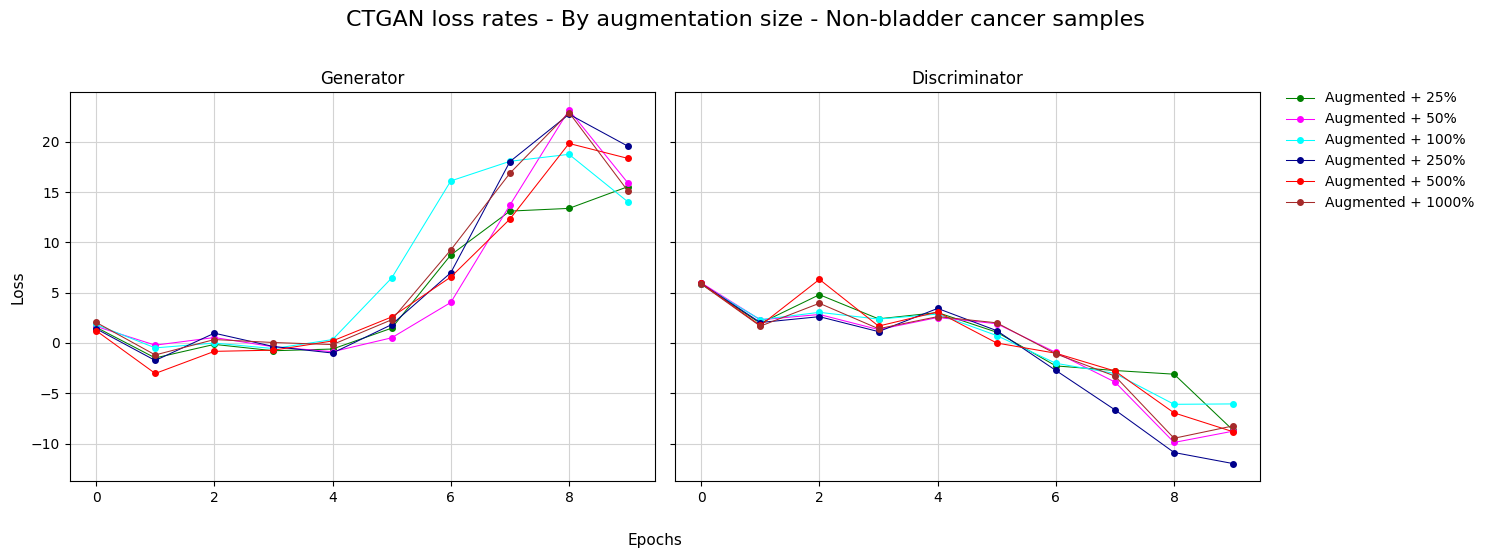

In [ ]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)

line_colors = ['green', 'magenta', 'cyan', 'darkblue', 'red', 'brown']

# Generator loss
axes[0].plot(loss_0_25['epoch'], loss_0_25['generator_loss'], label='Augmented + 25%', color=line_colors[0], marker='o', markersize=4, linewidth=0.75)
axes[0].plot(loss_0_50['epoch'], loss_0_50['generator_loss'], label='Augmented + 50%', color=line_colors[1], marker='o', markersize=4, linewidth=0.75)
axes[0].plot(loss_0_100['epoch'], loss_0_100['generator_loss'], label='Augmented + 100%', color=line_colors[2], marker='o', markersize=4, linewidth=0.75)
axes[0].plot(loss_0_250['epoch'], loss_0_250['generator_loss'], label='Augmented + 250%', color=line_colors[3], marker='o', markersize=4, linewidth=0.75)
axes[0].plot(loss_0_500['epoch'], loss_0_500['generator_loss'], label='Augmented + 500%', color=line_colors[4], marker='o', markersize=4, linewidth=0.75)
axes[0].plot(loss_0_1000['epoch'], loss_0_1000['generator_loss'], label='Augmented + 1000%', color=line_colors[5], marker='o', markersize=4, linewidth=0.75)
axes[0].set_title('Generator')
#axes[0].set_xlabel('Epoch',fontsize=11)
axes[0].set_ylabel('Loss',fontsize=11)
#axes[0].legend(frameon=False)
axes[0].grid(True,color='lightgrey')

# Discriminator loss
axes[1].plot(loss_0_25['epoch'], loss_0_25['critic_loss'], label='Augmented + 25%', color=line_colors[0], marker='o', markersize=4, linewidth=0.75)
axes[1].plot(loss_0_50['epoch'], loss_0_50['critic_loss'], label='Augmented + 50%', color=line_colors[1], marker='o', markersize=4, linewidth=0.75)
axes[1].plot(loss_0_100['epoch'], loss_0_100['critic_loss'], label='Augmented + 100%', color=line_colors[2], marker='o', markersize=4, linewidth=0.75)
axes[1].plot(loss_0_250['epoch'], loss_0_250['critic_loss'], label='Augmented + 250%', color=line_colors[3], marker='o', markersize=4, linewidth=0.75)
axes[1].plot(loss_0_500['epoch'], loss_0_500['critic_loss'], label='Augmented + 500%', color=line_colors[4], marker='o', markersize=4, linewidth=0.75)
axes[1].plot(loss_0_1000['epoch'], loss_0_1000['critic_loss'], label='Augmented + 1000%', color=line_colors[5], marker='o', markersize=4, linewidth=0.75)
axes[1].set_title('Discriminator')
#axes[1].set_xlabel('Epoch',fontsize=11)
#axes[1].set_ylabel('Loss',fontsize=11)
axes[1].legend(frameon=False,loc='upper left', bbox_to_anchor=(1, 1.07), borderaxespad=1.5)
axes[1].grid(True,color='lightgrey')

fig.suptitle('CTGAN loss rates - By augmentation size - Non-bladder cancer samples', y=1.02, fontsize=16)
fig.text(0.44, -0.05, 'Epochs', ha='center', fontsize=11)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()


#### 9.2. Class 1 - Bladder cancer

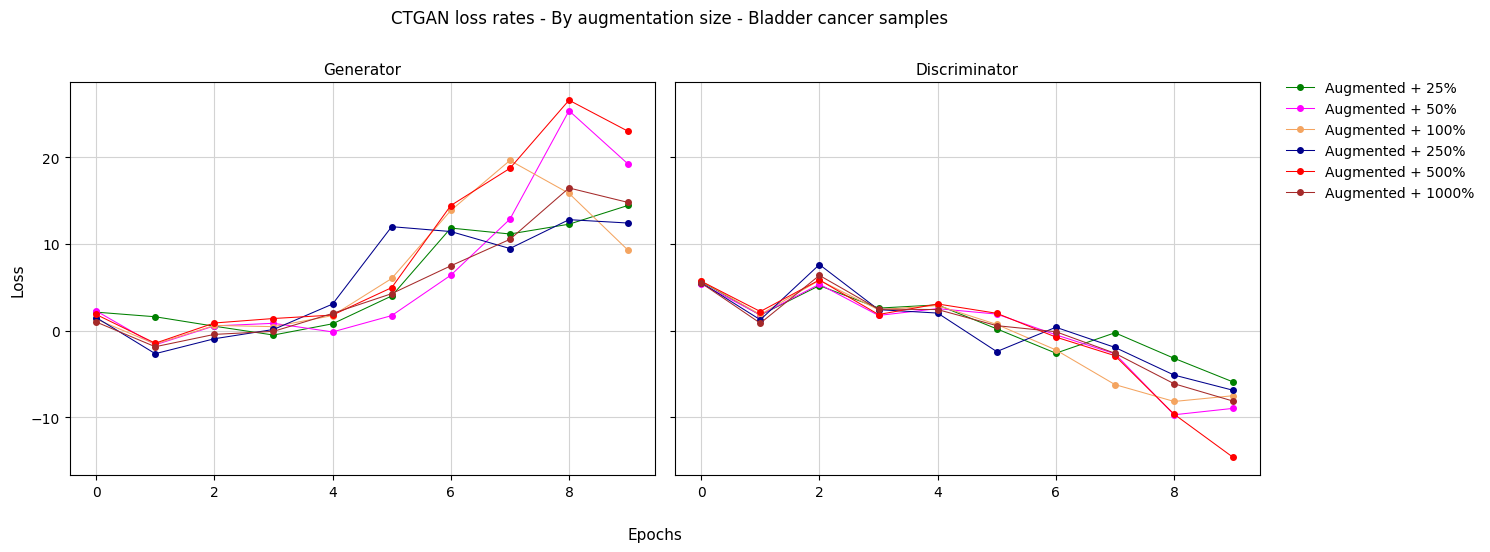

In [ ]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)

line_colors = ['green', 'magenta', 'sandybrown', 'darkblue', 'red', 'brown']

# Generator loss
axes[0].plot(loss_1_25['epoch'], loss_1_25['generator_loss'], label='Augmented + 25%', color=line_colors[0], marker='o', markersize=4, linewidth=0.75)
axes[0].plot(loss_1_50['epoch'], loss_1_50['generator_loss'], label='Augmented + 50%', color=line_colors[1], marker='o', markersize=4, linewidth=0.75)
axes[0].plot(loss_1_100['epoch'], loss_1_100['generator_loss'], label='Augmented + 100%', color=line_colors[2], marker='o', markersize=4, linewidth=0.75)
axes[0].plot(loss_1_250['epoch'], loss_1_250['generator_loss'], label='Augmented + 250%', color=line_colors[3], marker='o', markersize=4, linewidth=0.75)
axes[0].plot(loss_1_500['epoch'], loss_1_500['generator_loss'], label='Augmented + 500%', color=line_colors[4], marker='o', markersize=4, linewidth=0.75)
axes[0].plot(loss_1_1000['epoch'], loss_1_1000['generator_loss'], label='Augmented + 1000%', color=line_colors[5], marker='o', markersize=4, linewidth=0.75)
axes[0].set_title('Generator',fontsize=11)
#axes[0].set_xlabel('Epoch',fontsize=11)
axes[0].set_ylabel('Loss',fontsize=11)
#axes[0].legend(frameon=False)
axes[0].grid(True,color='lightgrey')

# Discriminator loss
axes[1].plot(loss_1_25['epoch'], loss_1_25['critic_loss'], label='Augmented + 25%', color=line_colors[0], marker='o', markersize=4, linewidth=0.75)
axes[1].plot(loss_1_50['epoch'], loss_1_50['critic_loss'], label='Augmented + 50%', color=line_colors[1], marker='o', markersize=4, linewidth=0.75)
axes[1].plot(loss_1_100['epoch'], loss_1_100['critic_loss'], label='Augmented + 100%', color=line_colors[2], marker='o', markersize=4, linewidth=0.75)
axes[1].plot(loss_1_250['epoch'], loss_1_250['critic_loss'], label='Augmented + 250%', color=line_colors[3], marker='o', markersize=4, linewidth=0.75)
axes[1].plot(loss_1_500['epoch'], loss_1_500['critic_loss'], label='Augmented + 500%', color=line_colors[4], marker='o', markersize=4, linewidth=0.75)
axes[1].plot(loss_1_1000['epoch'], loss_1_1000['critic_loss'], label='Augmented + 1000%', color=line_colors[5], marker='o', markersize=4, linewidth=0.75)
axes[1].set_title('Discriminator',fontsize=11)
#axes[1].set_xlabel('Epoch',fontsize=11)
#axes[1].set_ylabel('Loss',fontsize=11)
axes[1].legend(frameon=False,loc='upper left', bbox_to_anchor=(1, 1.07), borderaxespad=1.5)
axes[1].grid(True,color='lightgrey')

fig.suptitle('CTGAN loss rates - By augmentation size - Bladder cancer samples', x=0.45, y=1.01)
fig.text(0.44, -0.05, 'Epochs', ha='center', fontsize=11)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plots
plt.show()

#### 9.3. Selected augmented dataset

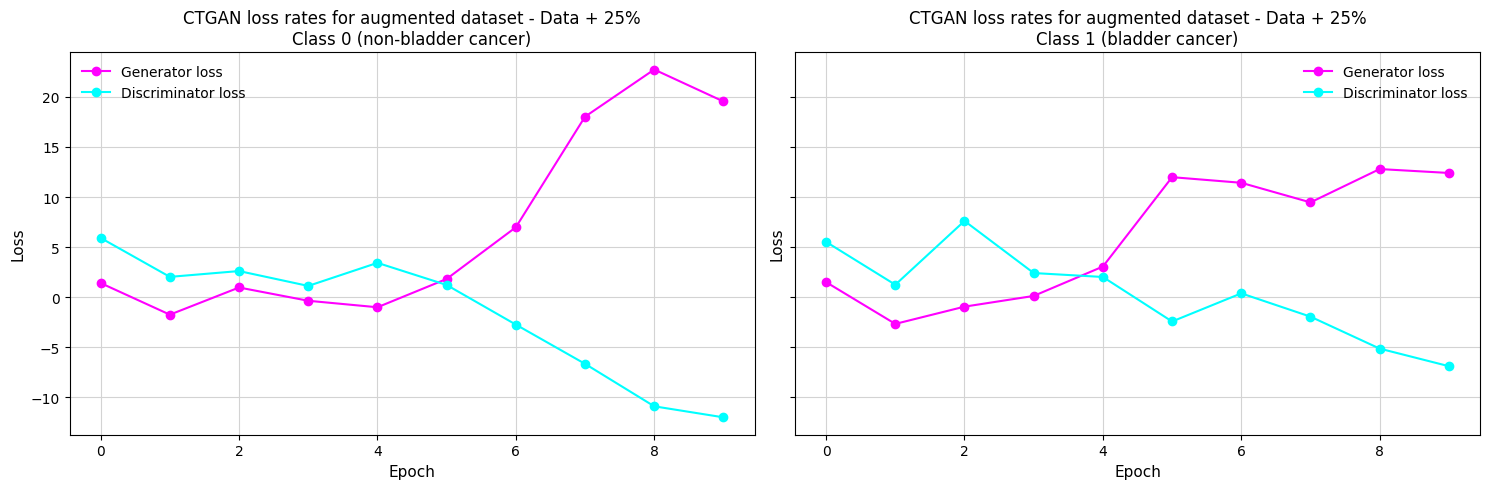

In [ ]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)

# loss_0_250
axes[0].plot(loss_0_250['epoch'], loss_0_250['generator_loss'], label='Generator loss', color='magenta', marker='o')
axes[0].plot(loss_0_250['epoch'], loss_0_250['critic_loss'], label='Discriminator loss', color='cyan', marker='o')
axes[0].set_title('CTGAN loss rates for augmented dataset - Data + 25%\nClass 0 (non-bladder cancer)')
axes[0].set_xlabel('Epoch',fontsize=11)
axes[0].set_ylabel('Loss',fontsize=11)
axes[0].legend(frameon=False)
axes[0].grid(True,color='lightgrey')

# loss_1_250
axes[1].plot(loss_1_250['epoch'], loss_1_250['generator_loss'], label='Generator loss', color='magenta', marker='o')
axes[1].plot(loss_1_250['epoch'], loss_1_250['critic_loss'], label='Discriminator loss', color='cyan', marker='o')
axes[1].set_title('CTGAN loss rates for augmented dataset - Data + 25%\nClass 1 (bladder cancer)')
axes[1].set_xlabel('Epoch',fontsize=11)
axes[1].set_ylabel('Loss',fontsize=11)
axes[1].legend(frameon=False)
axes[1].grid(True,color='lightgrey')

plt.tight_layout()

# Show the plots
plt.show()


### 10. Analysis : Stability of CTGAN
Calculate the variability in fidelity scores over multiple (5) iterations using the same hyperparameters for each augmentation scenario

#### 10.1 Calculate variability in the fidelity scores
Standard deviation is sensitive to the scale of the data so will use the coefficient of variation which normalizes by the mean

In [ ]:
#_bal
stability_0_bal_a=stability_0_bal.drop(columns=['tot_num_0','tot_cat_0','tot_0'])
stability_0_bal_t=(stability_0_bal_a.std()/stability_0_bal_a.mean())
df_0_bal_a=pd.DataFrame({'metric':stability_0_bal_t.index, 'value':stability_0_bal_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

stability_1_bal_a=stability_1_bal.drop(columns=['tot_num_1','tot_cat_1','tot_1'])
stability_1_bal_t=(stability_1_bal_a.std()/stability_1_bal_a.mean())
df_1_bal_a=pd.DataFrame({'metric':stability_1_bal_t.index, 'value':stability_1_bal_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

# _25
stability_0_25_a=stability_0_25.drop(columns=['tot_num_0','tot_cat_0','tot_0'])
stability_0_25_t=(stability_0_25_a.std()/stability_0_25_a.mean())
df_0_25_a = pd.DataFrame({'metric':stability_0_25_t.index, 'value':stability_0_25_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

stability_1_25_a=stability_1_25.drop(columns=['tot_num_1','tot_cat_1','tot_1'])
stability_1_25_t=(stability_1_25_a.std()/stability_1_25_a.mean())
df_1_25_a=pd.DataFrame({'metric':stability_1_25_t.index, 'value':stability_1_25_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

# _50
stability_0_50_a=stability_0_50.drop(columns=['tot_num_0','tot_cat_0','tot_0'])
stability_0_50_t=(stability_0_50_a.std()/stability_0_50_a.mean())
df_0_50_a = pd.DataFrame({'metric':stability_0_50_t.index, 'value':stability_0_50_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

stability_1_50_a=stability_1_50.drop(columns=['tot_num_1','tot_cat_1','tot_1'])
stability_1_50_t=(stability_1_50_a.std()/stability_1_50_a.mean())
df_1_50_a=pd.DataFrame({'metric':stability_1_50_t.index, 'value':stability_1_50_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

# _100
stability_0_100_a=stability_0_100.drop(columns=['tot_num_0','tot_cat_0','tot_0'])
stability_0_100_t=(stability_0_100_a.std()/stability_0_100_a.mean())
df_0_100_a = pd.DataFrame({'metric':stability_0_100_t.index, 'value':stability_0_100_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

stability_1_100_a=stability_1_100.drop(columns=['tot_num_1','tot_cat_1','tot_1'])
stability_1_100_t=(stability_1_100_a.std()/stability_1_100_a.mean())
df_1_100_a=pd.DataFrame({'metric':stability_1_100_t.index, 'value':stability_1_100_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

# _250
stability_0_250_a=stability_0_250.drop(columns=['tot_num_0','tot_cat_0','tot_0'])
stability_0_250_t=(stability_0_250_a.std()/stability_0_250_a.mean())
df_0_250_a = pd.DataFrame({'metric':stability_0_250_t.index, 'value':stability_0_250_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

stability_1_250_a=stability_1_250.drop(columns=['tot_num_1','tot_cat_1','tot_1'])
stability_1_250_t=(stability_1_250_a.std()/stability_1_250_a.mean())
df_1_250_a=pd.DataFrame({'metric':stability_1_250_t.index, 'value':stability_1_250_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

# _500
stability_0_500_a=stability_0_500.drop(columns=['tot_num_0','tot_cat_0','tot_0'])
stability_0_500_t=(stability_0_500_a.std()/stability_0_500_a.mean())
df_0_500_a = pd.DataFrame({'metric':stability_0_500_t.index, 'value':stability_0_500_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

stability_1_500_a=stability_1_500.drop(columns=['tot_num_1','tot_cat_1','tot_1'])
stability_1_500_t=(stability_1_500_a.std()/stability_1_500_a.mean())
df_1_500_a=pd.DataFrame({'metric':stability_1_500_t.index, 'value':stability_1_500_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

# _500
stability_0_500_a=stability_0_500.drop(columns=['tot_num_0','tot_cat_0','tot_0'])
stability_0_500_t=(stability_0_500_a.std()/stability_0_500_a.mean())
df_0_500_a = pd.DataFrame({'metric':stability_0_500_t.index, 'value':stability_0_500_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

stability_1_500_a=stability_1_500.drop(columns=['tot_num_1','tot_cat_1','tot_1'])
stability_1_500_t=(stability_1_500_a.std()/stability_1_500_a.mean())
df_1_500_a=pd.DataFrame({'metric':stability_1_500_t.index, 'value':stability_1_500_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

# _1000
stability_0_1000_a=stability_0_1000.drop(columns=['tot_num_0','tot_cat_0','tot_0'])
stability_0_1000_t=(stability_0_1000_a.std()/stability_0_1000_a.mean())
df_0_1000_a = pd.DataFrame({'metric':stability_0_1000_t.index, 'value':stability_0_1000_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

stability_1_1000_a=stability_1_1000.drop(columns=['tot_num_1','tot_cat_1','tot_1'])
stability_1_1000_t=(stability_1_1000_a.std()/stability_1_1000_a.mean())
df_1_1000_a=pd.DataFrame({'metric':stability_1_1000_t.index, 'value':stability_1_1000_t.values}).sort_values(by='metric').reset_index(drop=True).reindex([7,6,5,3,2,8,1,4,0]).reset_index(drop=True)

#### 10.2. Bring together all the variation coefficients

In [ ]:
# Class 0

#df_0_bal_b=df_0_bal_a.rename(columns={'metric':'Metric', 'value': 'Value:Bal'})
df_0_25_b=df_0_25_a.rename(columns={'metric':'Metric', 'value': 'Value:25%'})
df_0_50_b=df_0_50_a.rename(columns={'metric':'Metric', 'value': 'Value:50%'})
df_0_100_b=df_0_100_a.rename(columns={'metric':'Metric', 'value': 'Value:100%'})
df_0_250_b=df_0_250_a.rename(columns={'metric':'Metric', 'value': 'Value:250%'})
df_0_500_b=df_0_500_a.rename(columns={'metric':'Metric', 'value': 'Value:500%'})
df_0_1000_b=df_0_1000_a.rename(columns={'metric':'Metric', 'value': 'Value:1000%'})
#df_0_alla=pd.concat([df_0_bal_b, df_0_25_b['Value:25%'], df_0_50_b['Value:50%'], df_0_100_b['Value:100%'], df_0_250_b['Value:250%'], df_0_500_b['Value:500%'], df_0_1000_b['Value:1000%']], axis=1)
df_0_alla=pd.concat([df_0_25_b, df_0_50_b['Value:50%'], df_0_100_b['Value:100%'], df_0_250_b['Value:250%'], df_0_500_b['Value:500%'], df_0_1000_b['Value:1000%']], axis=1)
replace_dic2={'pcd_0':'PCD score', 'mmd_0':'MMD score', 'kld_0':'KLD score', 'gen_0':'Gender distn', 'hyp_0':'Hypertension distn', 'dia_0':'Diabetes distn', 'smo_0':'Smoking distn', 'dri_0':'Drinking distn', 'bee_0':'Bee1leNu1 distn'}
df_0_alla['Metric']=df_0_alla['Metric'].replace(replace_dic2)
df_0_alla

,Metric,Value:25%,Value:50%,Value:100%,Value:250%,Value:500%,Value:1000%
0,PCD score,0.044049,0.025538,0.058060,0.036550,0.042833,0.027673
1,MMD score,0.051129,0.230138,0.138688,0.131194,0.353034,0.158856
2,KLD score,0.000042,0.000033,0.000072,0.000072,0.000074,0.000034
3,Gender distn,0.670871,0.566242,0.593156,0.496236,0.281552,0.467296
4,Drinking distn,1.012363,0.246862,0.353918,0.844329,0.668977,0.416667
5,Smoking distn,1.337508,1.080931,0.740408,0.881689,0.721110,0.451656
6,Diabetes distn,1.109687,1.016560,0.610065,1.454574,1.198143,0.944764
7,Hypertension distn,0.460628,0.599976,0.862396,1.061753,0.620770,0.771292
8,Bee1leNu1 distn,0.353553,0.366882,0.288525,0.549229,0.181818,0.595174


In [ ]:
# Class 1

df_1_bal_b=df_1_bal_a.rename(columns={'metric':'Metric', 'value': 'Value:Bal'})
df_1_25_b=df_1_25_a.rename(columns={'metric':'Metric', 'value': 'Value:25%'})
df_1_50_b=df_1_50_a.rename(columns={'metric':'Metric', 'value': 'Value:50%'})
df_1_100_b=df_1_100_a.rename(columns={'metric':'Metric', 'value': 'Value:100%'})
df_1_250_b=df_1_250_a.rename(columns={'metric':'Metric', 'value': 'Value:250%'})
df_1_500_b=df_1_500_a.rename(columns={'metric':'Metric', 'value': 'Value:500%'})
df_1_1000_b=df_1_1000_a.rename(columns={'metric':'Metric', 'value': 'Value:1000%'})
#df_1_alla=pd.concat([df_1_bal_b, df_1_25_b['Value:25%'], df_1_50_b['Value:50%'], df_1_100_b['Value:100%'], df_1_250_b['Value:250%'], df_1_500_b['Value:500%'], df_1_1000_b['Value:1000%']], axis=1)
df_1_alla=pd.concat([df_1_25_b, df_1_50_b['Value:50%'], df_1_100_b['Value:100%'], df_1_250_b['Value:250%'], df_1_500_b['Value:500%'], df_1_1000_b['Value:1000%']], axis=1)
replace_dic2={'pcd_1':'PCD score', 'mmd_1':'MMD score', 'kld_1':'KLD score', 'gen_1':'Gender distn', 'hyp_1':'Hypertension distn', 'dia_1':'Diabetes distn', 'smo_1':'Smoking distn', 'dri_1':'Drinking distn', 'bee_1':'Bee1leNu1 distn'}
df_1_alla['Metric']=df_1_alla['Metric'].replace(replace_dic2)
df_1_alla

,Metric,Value:25%,Value:50%,Value:100%,Value:250%,Value:500%,Value:1000%
0,PCD score,0.024881,0.025692,0.031538,0.026629,0.019275,0.025600
1,MMD score,0.362371,0.365026,0.146904,0.190634,0.361257,0.093097
2,KLD score,0.000076,0.000792,0.000117,0.000105,0.000125,0.000319
3,Gender distn,0.574518,0.405674,0.575458,0.750025,0.302076,0.490153
4,Drinking distn,0.738166,0.803897,0.514459,0.448116,0.919295,0.504387
5,Smoking distn,0.155632,0.966640,0.643585,0.515475,0.609697,0.846921
6,Diabetes distn,0.378151,1.243491,0.598860,0.724910,1.259640,0.926587
7,Hypertension distn,0.365115,0.504273,0.747824,0.199389,0.512828,0.962028
8,Bee1leNu1 distn,0.399890,0.574293,0.399947,0.552511,0.376872,0.439697


#### 10.3. Radar plots of variation coefficients for each class

##### 10.3.1. Class 0 - non-bladder cancer

In [ ]:
categories = ['PCD','MMD','KLD','Gender','Drinking','Smoking','Diabe1es','Hyper1en1ion','Bee1leNu1']
categories = [*categories, categories[0]]

#df_0_bal_values = df_0_bal_a['value']
df_0_25_values = df_0_25_a['value']
df_0_50_values = df_0_50_a['value']
df_0_100_values = df_0_100_a['value']
df_0_250_values = df_0_250_a['value']
df_0_500_values = df_0_500_a['value']
df_0_1000_values = df_0_1000_a['value']

#df_0_bal_values = [*df_0_bal_values, df_0_bal_values[0]]
df_0_25_values = [*df_0_25_values, df_0_25_values[0]]
df_0_50_values = [*df_0_50_values, df_0_50_values[0]]
df_0_100_values = [*df_0_100_values, df_0_100_values[0]]
df_0_250_values = [*df_0_250_values, df_0_250_values[0]]
df_0_500_values = [*df_0_500_values, df_0_500_values[0]]
df_0_1000_values = [*df_0_1000_values, df_0_1000_values[0]]

line_colors = ['green', 'magenta', 'cyan', 'darkblue', 'red', 'brown']

fig = go.Figure(
    #data=[go.Scatterpolar(r=df_0_bal_values, theta=categories, name='Balanced', line_color=line_colors[0]),
    data=[go.Scatterpolar(r=df_0_25_values, theta=categories, name='Augmented + 25%', line_color=line_colors[0]),
          go.Scatterpolar(r=df_0_50_values, theta=categories, name='Augmented + 50%', line_color=line_colors[1]),
          go.Scatterpolar(r=df_0_100_values, theta=categories, name='Augmented + 100%', line_color=line_colors[2]),
          go.Scatterpolar(r=df_0_250_values, theta=categories, name='Augmented + 250%', line_color=line_colors[3]),
          go.Scatterpolar(r=df_0_500_values, theta=categories, name='Augmented + 500%', line_color=line_colors[4]),
          go.Scatterpolar(r=df_0_1000_values, theta=categories, name='Augmented + 1,000%', line_color=line_colors[5])],
    layout=go.Layout(title=go.layout.Title(text='CTGAN performance variability - normalized scores - 5 iterations - Non-bladder cancer'),
                     polar={'radialaxis': {'visible': True, 'gridcolor': 'rgba(0, 0, 0, 0.1)'},
                            'angularaxis': {'visible': True, 'gridcolor': 'rgba(0, 0, 0, 0.1)'}},
                     legend=dict(x=1.25, y=0.63),
                     showlegend=True))

# Adjust the left margin to move the plot to the left
fig.update_layout(margin=dict(r=1200), # Position of plot (pixels)
                  title=dict(x=0, y=0.68),
                  height=1500, width=1700) # Size of the plot
pyo.iplot(fig)

##### 10.3.2. Class 1 - bladder cancer

In [ ]:
categories = ['PCD','MMD','KLD','Gender','Drinking','Smoking','Diabe1es','Hyper1en1ion','Bee1leNu1']
categories = [*categories, categories[0]]

#df_1_bal_values = df_1_bal_a['value']
df_1_25_values = df_1_25_a['value']
df_1_50_values = df_1_50_a['value']
df_1_100_values = df_1_100_a['value']
df_1_250_values = df_1_250_a['value']
df_1_500_values = df_1_500_a['value']
df_1_1000_values = df_1_1000_a['value']

#df_1_bal_values = [*df_1_bal_values, df_1_bal_values[0]]
df_1_25_values = [*df_1_25_values, df_1_25_values[0]]
df_1_50_values = [*df_1_50_values, df_1_50_values[0]]
df_1_100_values = [*df_1_100_values, df_1_100_values[0]]
df_1_250_values = [*df_1_250_values, df_1_250_values[0]]
df_1_500_values = [*df_1_500_values, df_1_500_values[0]]
df_1_1000_values = [*df_1_1000_values, df_1_1000_values[0]]

line_colors = ['green', 'magenta', 'cyan', 'darkblue', 'red', 'brown']

fig = go.Figure(
    #data=[go.Scatterpolar(r=df_1_bal_values, theta=categories, name='Balanced', line_color=line_colors[0]),
    data=[go.Scatterpolar(r=df_1_25_values, theta=categories, name='Augmented + 25%', line_color=line_colors[0]),
          go.Scatterpolar(r=df_1_50_values, theta=categories, name='Augmented + 50%', line_color=line_colors[1]),
          go.Scatterpolar(r=df_1_100_values, theta=categories, name='Augmented + 100%', line_color=line_colors[2]),
          go.Scatterpolar(r=df_1_250_values, theta=categories, name='Augmented + 250%', line_color=line_colors[3]),
          go.Scatterpolar(r=df_1_500_values, theta=categories, name='Augmented + 500%', line_color=line_colors[4]),
          go.Scatterpolar(r=df_1_1000_values, theta=categories, name='Augmented + 1,000%', line_color=line_colors[5])],
    layout=go.Layout(title=go.layout.Title(text='CTGAN performance variability - normalized scores - 5 iterations - Bladder cancer'),
                     polar={'radialaxis': {'visible': True, 'gridcolor': 'rgba(0, 0, 0, 0.1)'},
                            'angularaxis': {'visible': True, 'gridcolor': 'rgba(0, 0, 0, 0.1)'}},
                     legend=dict(x=1.25, y=0.63),
                     showlegend=True))

# Adjust the left margin to move the plot to the left
fig.update_layout(margin=dict(r=1200), # Position of plot (pixels)
                  title=dict(x=0, y=0.68),
                  height=1500, width=1700) # Size of the plot
pyo.iplot(fig)

##### 10.3.3. Subplots approach

In [ ]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'polar'}] * 2] * 1)

categories = ['PCD score','MMD score','KLD score','Gender distn','Drinking distn','Smoking distn','Diabe1es distn','Hyper1en1ion distn','Bee1leNu1 distn']
categories = [*categories, categories[0]]

df_0_bal_values = df_0_bal_a['value']
df_0_25_values = df_0_25_a['value']
df_0_50_values = df_0_50_a['value']
df_0_100_values = df_0_100_a['value']
df_0_250_values = df_0_250_a['value']
df_0_500_values = df_0_500_a['value']
df_0_1000_values = df_0_1000_a['value']

df_0_bal_values = [*df_0_bal_values, df_0_bal_values[0]]
df_0_25_values = [*df_0_25_values, df_0_25_values[0]]
df_0_50_values = [*df_0_50_values, df_0_50_values[0]]
df_0_100_values = [*df_0_100_values, df_0_100_values[0]]
df_0_250_values = [*df_0_250_values, df_0_250_values[0]]
df_0_500_values = [*df_0_500_values, df_0_500_values[0]]
df_0_1000_values = [*df_0_1000_values, df_0_1000_values[0]]

df_1_bal_values = df_1_bal_a['value']
df_1_25_values = df_1_25_a['value']
df_1_50_values = df_1_50_a['value']
df_1_100_values = df_1_100_a['value']
df_1_250_values = df_1_250_a['value']
df_1_500_values = df_1_500_a['value']
df_1_1000_values = df_1_1000_a['value']

df_1_bal_values = [*df_1_bal_values, df_1_bal_values[0]]
df_1_25_values = [*df_1_25_values, df_1_25_values[0]]
df_1_50_values = [*df_1_50_values, df_1_50_values[0]]
df_1_100_values = [*df_1_100_values, df_1_100_values[0]]
df_1_250_values = [*df_1_250_values, df_1_250_values[0]]
df_1_500_values = [*df_1_500_values, df_1_500_values[0]]
df_1_1000_values = [*df_1_1000_values, df_1_1000_values[0]]

line_colors = ['green', 'magenta', 'cyan', 'darkblue', 'red', 'brown']

##### First plot - class 0

# _bal
# fig.add_trace(go.Scatterpolar(theta=categories,r=df_0_bal_values,name='Balanced data', showlegend=False),
#               row=1,
#               col=1)
# _25
fig.add_trace(go.Scatterpolar(theta=categories,r=df_0_25_values,name='Augmented +25%', showlegend=False, line_color=line_colors[0]),
              row=1,
              col=1)
# _50
fig.add_trace(go.Scatterpolar(theta=categories,r=df_0_50_values,name='Augmented +50%', showlegend=False, line_color=line_colors[1]),
              row=1,
              col=1)
# _100
fig.add_trace(go.Scatterpolar(theta=categories,r=df_0_100_values,name='Augmented +100%', showlegend=False, line_color=line_colors[2]),
              row=1,
              col=1)
# _250
fig.add_trace(go.Scatterpolar(theta=categories,r=df_0_250_values,name='Augmented +250%', showlegend=False, line_color=line_colors[3]),
              row=1,
              col=1)
# _500
fig.add_trace(go.Scatterpolar(theta=categories,r=df_0_500_values,name='Augmented +500%', showlegend=False, line_color=line_colors[4]),
              row=1,
              col=1)
# _1000
fig.add_trace(go.Scatterpolar(theta=categories,r=df_0_1000_values,name='Augmented +1000%', showlegend=False, line_color=line_colors[5]),
              row=1,
              col=1)

##### Second plot - class 1

# _bal
# fig.add_trace(go.Scatterpolar(theta=categories,r=df_1_bal_values,name='Balanced data'),
#               row=1,
#               col=2)
# _25
fig.add_trace(go.Scatterpolar(theta=categories,r=df_1_25_values,name='Augmented +25%', line_color=line_colors[0]),
              row=1,
              col=2)
# _50
fig.add_trace(go.Scatterpolar(theta=categories,r=df_1_50_values,name='Augmented +50%', line_color=line_colors[1]),
              row=1,
              col=2)
# _100
fig.add_trace(go.Scatterpolar(theta=categories,r=df_1_100_values,name='Augmented +100%', line_color=line_colors[2]),
              row=1,
              col=2)
# _250
fig.add_trace(go.Scatterpolar(theta=categories,r=df_1_250_values,name='Augmented +250%', line_color=line_colors[3]),
              row=1,
              col=2)
# _500
fig.add_trace(go.Scatterpolar(theta=categories,r=df_1_500_values,name='Augmented +500%', line_color=line_colors[4]),
              row=1,
              col=2)
# _1000
fig.add_trace(go.Scatterpolar(theta=categories,r=df_1_1000_values,name='Augmented +1000%', line_color=line_colors[5]),
              row=1,
              col=2)

# Update layout for the first polar subplot
fig.update_polars(dict(radialaxis=dict(tickvals=[0, 0.2, 0.4, 0.6, 0.8, 1], ticktext=['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])),
                  row=1, col=1)

# Update layout for the second polar subplot
fig.update_polars(dict(radialaxis=dict(tickvals=[0, 0.2, 0.4, 0.6, 0.8, 1], ticktext=['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])),
                  row=1, col=2)

# Update common layout settings
fig.update_layout(title_text="CTGAN reliability - variability in performance metrics (normalized)",
                  title_font_size=20,
                  title_y=0.98,
                  annotations=[dict(text="Non-bladder cancer",x=0.18, y=-0.25, xref="paper", yref="paper", showarrow=False, font=dict(size=17)),
                               dict(text="Bladder cancer", x=0.81, y=-0.25, xref="paper", yref="paper", showarrow=False, font=dict(size=17))])
# Show the plot
fig.show()

### 11. Analysis : Feature distribution analysis - real versus synthetic


#### 11.1. Get real and synthetic data per augmentation scenario

In [ ]:
# Real data by class from above
df_imp_t_0=df_t_0.copy()
df_imp_t_1=df_t_1.copy()

# Get synthetic data by scenario and class
#train_bal_df_synth_0=aug_bal.loc[(aug_bal['disease1']==0) & (aug_bal['type']=='synth')].drop(columns=['type'],axis=1)
#train_bal_df_synth_1=aug_bal.loc[(aug_bal['disease1']==1) & (aug_bal['type']=='synth')].drop(columns=['type'],axis=1)
train_bal_25_df_synth_0=aug_25.loc[(aug_25['disease1']==0) & (aug_25['type']=='synth')].drop(columns=['type'],axis=1)
train_bal_25_df_synth_1=aug_25.loc[(aug_25['disease1']==1) & (aug_25['type']=='synth')].drop(columns=['type'],axis=1)
train_bal_50_df_synth_0=aug_50.loc[(aug_50['disease1']==0) & (aug_50['type']=='synth')].drop(columns=['type'],axis=1)
train_bal_50_df_synth_1=aug_50.loc[(aug_50['disease1']==1) & (aug_50['type']=='synth')].drop(columns=['type'],axis=1)
train_bal_100_df_synth_0=aug_100.loc[(aug_100['disease1']==0) & (aug_100['type']=='synth')].drop(columns=['type'],axis=1)
train_bal_100_df_synth_1=aug_100.loc[(aug_100['disease1']==1) & (aug_100['type']=='synth')].drop(columns=['type'],axis=1)
train_bal_250_df_synth_0=aug_250.loc[(aug_250['disease1']==0) & (aug_250['type']=='synth')].drop(columns=['type'],axis=1)
train_bal_250_df_synth_1=aug_250.loc[(aug_250['disease1']==1) & (aug_250['type']=='synth')].drop(columns=['type'],axis=1)
train_bal_500_df_synth_0=aug_500.loc[(aug_500['disease1']==0) & (aug_500['type']=='synth')].drop(columns=['type'],axis=1)
train_bal_500_df_synth_1=aug_500.loc[(aug_500['disease1']==1) & (aug_500['type']=='synth')].drop(columns=['type'],axis=1)
train_bal_1000_df_synth_0=aug_1000.loc[(aug_1000['disease1']==0) & (aug_1000['type']=='synth')].drop(columns=['type'],axis=1)
train_bal_1000_df_synth_1=aug_1000.loc[(aug_1000['disease1']==1) & (aug_1000['type']=='synth')].drop(columns=['type'],axis=1)

data_0 = pd.concat([df_imp_t_0.assign(Group='Real'),
                    #train_bal_df_synth_0.assign(Group='Bal'),
                    train_bal_25_df_synth_0.assign(Group='+25%'),
                    train_bal_50_df_synth_0.assign(Group='+50%'),
                    train_bal_100_df_synth_0.assign(Group='+100%'),
                    train_bal_250_df_synth_0.assign(Group='+250%'),
                    train_bal_500_df_synth_0.assign(Group='+500%'),
                    train_bal_1000_df_synth_0.assign(Group='+1,000%')])

data_1 = pd.concat([df_imp_t_1.assign(Group='Real'),
                    #train_bal_df_synth_1.assign(Group='Bal'),
                    train_bal_25_df_synth_1.assign(Group='+25%'),
                    train_bal_50_df_synth_1.assign(Group='+50%'),
                    train_bal_100_df_synth_1.assign(Group='+100%'),
                    train_bal_250_df_synth_1.assign(Group='+250%'),
                    train_bal_500_df_synth_1.assign(Group='+500%'),
                    train_bal_1000_df_synth_1.assign(Group='+1,000%')])

#### 11.2. Create visual comparison plots - real vs. synthetic for each feature across augmentation scenarios

In [ ]:
# Set up subplots
fig, axes=plt.subplots(36,2,figsize=(30,280))

# Over-arching title of all plots
fig.suptitle('All augmented datasets - synthetic versus real - distribution of sample values',fontsize=24,y=1)

# Set a text font size scaling factor to make all text readable
sns.set(font_scale=1.25)

# Plot for each feature
stackplot_all_aug('gender','Male','Female',0)

box_whisk_plot('Group','age',data_0,'age - non-bladder cancer',1,0)
box_whisk_plot('Group','age',data_1,'age - bladder cancer',1,1)

stackplot_all_aug('smoking','Non-smoker','Smoker',2)
stackplot_all_aug('drinking','Non-drinker','Drinker',3)
stackplot_all_aug('diabe1es','Non-diabetic','Diabetic',4)
stackplot_all_aug('hyper1en1ion','Non-hypertension','Hypertension',5)
stackplot_all_aug('bee1lenu1','Non-bee1lenu1','bee1lenu1',6)

box_whisk_plot('Group','albumin',data_0,'albumin - non-bladder cancer',7,0)
box_whisk_plot('Group','albumin',data_1,'albumin - bladder cancer',7,1)

box_whisk_plot('Group','alk',data_0,'alk - non-bladder cancer',8,0)
box_whisk_plot('Group','alk',data_1,'alk - bladder cancer',8,1)

box_whisk_plot('Group','alt_gpt',data_0,'alt_gpt - non-bladder cancer',9,0)
box_whisk_plot('Group','alt_gpt',data_1,'alt_gpt - bladder cancer',9,1)

box_whisk_plot('Group','ast_got',data_0,'ast_got - non-bladder cancer',10,0)
box_whisk_plot('Group','ast_got',data_1,'ast_got - bladder cancer',10,1)

box_whisk_plot('Group','bun',data_0,'bun - non-bladder cancer',11,0)
box_whisk_plot('Group','bun',data_1,'bun - bladder cancer',11,1)

box_whisk_plot('Group','calcium',data_0,'calcium - non-bladder cancer',12,0)
box_whisk_plot('Group','calcium',data_1,'calcium - bladder cancer',12,1)

box_whisk_plot('Group','chloride',data_0,'chloride - non-bladder cancer',13,0)
box_whisk_plot('Group','chloride',data_1,'chloride - bladder cancer',13,1)

box_whisk_plot('Group','creatinine',data_0,'creatinine - non-bladder cancer',14,0)
box_whisk_plot('Group','creatinine',data_1,'creatinine - bladder cancer',14,1)

box_whisk_plot('Group','direct_bilirubin',data_0,'direct_bilirubin - non-bladder cancer',15,0)
box_whisk_plot('Group','direct_bilirubin',data_1,'direct_bilirubin - bladder cancer',15,1)

box_whisk_plot('Group','estimated_gfr',data_0,'estimated_gfr - non-bladder cancer',16,0)
box_whisk_plot('Group','estimated_gfr',data_1,'estimated_gfr - bladder cancer',16,1)

box_whisk_plot('Group','glucose_ac',data_0,'glucose_ac - non-bladder cancer',17,0)
box_whisk_plot('Group','glucose_ac',data_1,'glucose_ac - bladder cancer',17,1)

box_whisk_plot('Group','nitrite',data_0,'nitrite - non-bladder cancer',18,0)
box_whisk_plot('Group','nitrite',data_1,'nitrite - bladder cancer',18,1)

box_whisk_plot('Group','urine_occult_blood',data_0,'urine_occult_blood - non-bladder cancer',19,0)
box_whisk_plot('Group','urine_occult_blood',data_1,'urine_occult_blood - bladder cancer',19,1)

box_whisk_plot('Group','ph',data_0,'ph - non-bladder cancer',20,0)
box_whisk_plot('Group','ph',data_1,'ph - bladder cancer',20,1)

box_whisk_plot('Group','potassium',data_0,'potassium - non-bladder cancer',21,0)
box_whisk_plot('Group','potassium',data_1,'potassium - bladder cancer',21,1)

box_whisk_plot('Group','sodium',data_0,'sodium - non-bladder cancer',22,0)
box_whisk_plot('Group','sodium',data_1,'sodium - bladder cancer',22,1)

box_whisk_plot('Group','specific_gravity',data_0,'specific_gravity - non-bladder cancer',23,0)
box_whisk_plot('Group','specific_gravity',data_1,'specific_gravity - bladder cancer',23,1)

box_whisk_plot('Group','strip_wbc',data_0,'strip_wbc - non-bladder cancer',24,0)
box_whisk_plot('Group','strip_wbc',data_1,'strip_wbc - bladder cancer',24,1)

box_whisk_plot('Group','total_bilirubin',data_0,'total_bilirubin - non-bladder cancer',25,0)
box_whisk_plot('Group','total_bilirubin',data_1,'total_bilirubin - bladder cancer',25,1)

box_whisk_plot('Group','total_cholesterol',data_0,'total_cholesterol - non-bladder cancer',26,0)
box_whisk_plot('Group','total_cholesterol',data_1,'total_cholesterol - bladder cancer',26,1)

box_whisk_plot('Group','total_protein',data_0,'total_protein - non-bladder cancer',27,0)
box_whisk_plot('Group','total_protein',data_1,'total_protein - bladder cancer',27,1)

box_whisk_plot('Group','triglyceride',data_0,'triglyceride - non-bladder cancer',28,0)
box_whisk_plot('Group','triglyceride',data_1,'triglyceride - bladder cancer',28,1)

box_whisk_plot('Group','urine_epithelium_count',data_0,'urine_epithelium_count - non-bladder cancer',29,0)
box_whisk_plot('Group','urine_epithelium_count',data_1,'urine_epithelium_count - bladder cancer',29,1)

box_whisk_plot('Group','uric_acid',data_0,'uric_acid - non-bladder cancer',30,0)
box_whisk_plot('Group','uric_acid',data_1,'uric_acid - bladder cancer',30,1)

box_whisk_plot('Group','urine_bilirubin',data_0,'urine_bilirubin - non-bladder cancer',31,0)
box_whisk_plot('Group','urine_bilirubin',data_1,'urine_bilirubin - bladder cancer',31,1)

box_whisk_plot('Group','urine_glucose',data_0,'urine_glucose - non-bladder cancer',32,0)
box_whisk_plot('Group','urine_glucose',data_1,'urine_glucose - bladder cancer',32,1)

box_whisk_plot('Group','urine_ketone',data_0,'urine_ketone - non-bladder cancer',33,0)
box_whisk_plot('Group','urine_ketone',data_1,'urine_ketone - bladder cancer',33,1)

box_whisk_plot('Group','urine_protein',data_0,'urine_protein - non-bladder cancer',34,0)
box_whisk_plot('Group','urine_protein',data_1,'urine_protein - bladder cancer',34,1)

box_whisk_plot('Group','urobilinogen',data_0,'urobilinogen - non-bladder cancer',35,0)
box_whisk_plot('Group','urobilinogen',data_1,'urobilinogen - bladder cancer',35,1)

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### 12. Analysis : Feature correlations - real versus synthetic

- Again, using the augmented datasets with the best fidelity from each augmentation scenario
- Only considers continuous features
- As per in the EDA use Spearman rank correlation coefficient method as:
  - Measures the monotonic relationship between two variables (whether the relationship is strictly increasing or decreasing)
  - Does not assume linearity or normal distribution
  - Less sensitive to outliers than Pearson correlation
  - Suitable for both continuous and ordinal (rank-ordered)

#### 12.1 Calculate the correlations within each augmented dataset and compare with real data - 'non-bladder cancer' class

In [ ]:
# Real data by class from above
#df_imp_t_0
#df_imp_t_1

# Synthetic data by scenario and class from above
# train_bal_df_synth_0
# train_bal_25_df_synth_0
# train_bal_50_df_synth_0
# train_bal_100_df_synth_0
# train_bal_250_df_synth_0
# train_bal_500_df_synth_0
# train_bal_1000_df_synth_0

# train_bal_df_synth_1
# train_bal_25_df_synth_1
# train_bal_50_df_synth_1
# train_bal_100_df_synth_1
# train_bal_250_df_synth_1
# train_bal_500_df_synth_1
# train_bal_1000_df_synth_1

In [ ]:
# Set up subplots
fig, axes=plt.subplots(6,2,figsize=(80,200),constrained_layout=True)

# Over-arching title of all plots
fig.suptitle('Spearman rank correlation coefficents - synthetic versus real - non-bladder cancer - transformed data \n (-1=perfect negative monotonic relationship, 1=perfect positive monotonic relationship)',fontsize=60,y=1.02)

# Real data vs balanced synthetic data
corr_0=df_imp_t_0.corr(method='spearman')
# heatmap_plot(corr_0,'Real data',0,0)
# corr_0a=train_bal_df_synth_0.corr(method='spearman')
# heatmap_plot(corr_0a,'Synthetic balanced data',0,1)

# Real data vs +25% synthetic data
heatmap_plot(corr_0,'Real data',0,0) # By removing 'Bal' had to change all the subplot position for the remaining plots
corr_0b=train_bal_25_df_synth_0.corr(method='spearman')
heatmap_plot(corr_0b,'Synthetic +25% data',0,1)

# Real data vs +50% synthetic data
heatmap_plot(corr_0,'Real data',1,0)
corr_0c=train_bal_50_df_synth_0.corr(method='spearman')
heatmap_plot(corr_0c,'Synthetic +50% data',1,1)

# Real data vs +100% synthetic data
heatmap_plot(corr_0,'Real data',2,0)
corr_0d=train_bal_100_df_synth_0.corr(method='spearman')
heatmap_plot(corr_0d,'Synthetic +100% data',2,1)

# Real data vs +250% synthetic data
heatmap_plot(corr_0,'Real data',3,0)
corr_0e=train_bal_250_df_synth_0.corr(method='spearman')
heatmap_plot(corr_0e,'Synthetic +250% data',3,1)

# Real data vs +500% synthetic data
heatmap_plot(corr_0,'Real data',4,0)
corr_0f=train_bal_500_df_synth_0.corr(method='spearman')
heatmap_plot(corr_0f,'Synthetic +500% data',4,1)

# Real data vs +1,000% synthetic data
heatmap_plot(corr_0,'Real data',5,0)
corr_0g=train_bal_1000_df_synth_0.corr(method='spearman')
heatmap_plot(corr_0g,'Synthetic +1,000% data',5,1)

plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### 12.2 Calculate the correlations within each augmented dataset and compare with real data - 'bladder cancer' class

In [ ]:
# Set up subplots
fig, axes=plt.subplots(6,2,figsize=(80,170),constrained_layout=True)

# Over-arching title of all plots
fig.suptitle('Spearman rank correlation coefficents - synthetic versus real - bladder cancer - transformed data \n (-1=perfect negative monotonic relationship, 1=perfect positive monotonic relationship)',fontsize=60,y=1.02)

# Real data vs balanced synthetic data
corr_1=df_imp_t_1.corr(method='spearman')
# heatmap_plot(corr_1,'Real data',0,0)
# corr_1a=train_bal_df_synth_1.corr(method='spearman')
# heatmap_plot(corr_1a,'Synthetic balanced data',0,1)

# Real data vs +25% synthetic data
heatmap_plot(corr_1,'Real data',0,0)
corr_1b=train_bal_25_df_synth_1.corr(method='spearman')
heatmap_plot(corr_1b,'Synthetic +25% data',0,1)

# Real data vs +50% synthetic data
heatmap_plot(corr_1,'Real data',1,0)
corr_1c=train_bal_50_df_synth_1.corr(method='spearman')
heatmap_plot(corr_1c,'Synthetic +50% data',1,1)

# Real data vs +100% synthetic data
heatmap_plot(corr_1,'Real data',2,0)
corr_1d=train_bal_100_df_synth_1.corr(method='spearman')
heatmap_plot(corr_1d,'Synthetic +100% data',2,1)

# Real data vs +250% synthetic data
heatmap_plot(corr_1,'Real data',3,0)
corr_1e=train_bal_250_df_synth_1.corr(method='spearman')
heatmap_plot(corr_1e,'Synthetic +250% data',3,1)

# Real data vs +500% synthetic data
heatmap_plot(corr_1,'Real data',4,0)
corr_1f=train_bal_500_df_synth_1.corr(method='spearman')
heatmap_plot(corr_1f,'Synthetic +500% data',4,1)

# Real data vs +1,000% synthetic data
heatmap_plot(corr_1,'Real data',5,0)
corr_1g=train_bal_1000_df_synth_1.corr(method='spearman')
heatmap_plot(corr_1g,'Synthetic +1,000% data',5,1)

plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### 12.3 Calculate Euclidean distances between the correlation matrices for both classes
Smaller distances means greater similarity while larger distances mean greater dissimilarity

In [ ]:
# Class 0 - 'non-bladder cancer'

eucl_0_dic={#'Real vs balanced':round(euclidean_distance(corr_0, corr_0a),3),
            'Real vs augmented 25%':round(euclidean_distance(corr_0, corr_0b),3),
            'Real vs augmented 50%':round(euclidean_distance(corr_0, corr_0c),3),
            'Real vs augmented 100%':round(euclidean_distance(corr_0, corr_0d),3),
            'Real vs augmented 250%':round(euclidean_distance(corr_0, corr_0e),3),
            'Real vs augmented 500%':round(euclidean_distance(corr_0, corr_0f),3),
            'Real vs augmented 1000%':round(euclidean_distance(corr_0, corr_0g),3)}

# Class 1 - 'non-bladder cancer'

eucl_1_dic={#'Real vs balanced':round(euclidean_distance(corr_1, corr_1a),3),
            'Real vs augmented 25%':round(euclidean_distance(corr_1, corr_1b),3),
            'Real vs augmented 50%':round(euclidean_distance(corr_1, corr_1c),3),
            'Real vs augmented 100%':round(euclidean_distance(corr_1, corr_1d),3),
            'Real vs augmented 250%':round(euclidean_distance(corr_1, corr_1e),3),
            'Real vs augmented 500%':round(euclidean_distance(corr_1, corr_1f),3),
            'Real vs augmented 1000%':round(euclidean_distance(corr_1, corr_1g),3)}

# Bring together both into a df
df_eucl_0=pd.DataFrame(list(eucl_0_dic.items()),columns=['Comparison', 'Non-bladder cancer'])
df_eucl_1=pd.DataFrame(list(eucl_1_dic.items()),columns=['Comparison', 'Bladder cancer'])

# Merge DataFrames on the 'Comparison' column
df_eucl=pd.merge(df_eucl_0,df_eucl_1,on='Comparison')

# Display the merged DataFrame
df_eucl

,Comparison,Non-bladder cancer,Bladder cancer
0,Real vs augmented 25%,6.800,6.608
1,Real vs augmented 50%,10.540,10.146
2,Real vs augmented 100%,6.122,9.198
3,Real vs augmented 250%,8.652,5.486
4,Real vs augmented 500%,7.281,8.785
5,Real vs augmented 1000%,8.869,5.975
